# initial steps
Seeding

In [ ]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Seeds set:", SEED)

Seeds set: 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Larger Dataset

In [ ]:
def combineDataset(dirpath):
  print(dirpath);
  for filename in os.listdir(dirpath):
    print(filename);

## Opening Dataset

### Parser Functions

In [ ]:
def parse_ctrlmsgs(file_path):
    rows = []
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("%") or line.startswith("Time"):
                continue  # Skip comments and header
            parts = line.strip().split()
            if len(parts) < 11:
                continue  # Skip malformed lines
            try:
                time = float(parts[0])
                entity = " ".join(parts[1:3])  # 'gNB MAC Rxed'
                rest = parts[3:]
                frame= rest[0]
                sframe, slot, vtti = map(int, rest[1:4])
                nodeId, rnti, bwpId = map(int, rest[4:7])
                msg_type = rest[7]
                rows.append([time, entity, frame, sframe, slot, vtti, nodeId, rnti, bwpId, msg_type])
            except ValueError:
                continue  # In case anything fails to parse

    # Create DataFrame
    cqi_df = pd.DataFrame(rows, columns=[
        "time", "entity", "frame", "sframe", "slot", "VarTTI", "nodeId", "RNTI", "bwpId", "msgType"
    ])

    return cqi_df

In [ ]:
def parse_macstats(file_path):
    mac_stats = pd.read_csv(file_path, comment="%", sep='\s+', header=None)
    mac_stats.columns = ["time", "cellId", "bwpId", "IMSI", "RNTI", "frame", "sframe", "slot","symStart", "numSym", "harqId", "ndi", "rv", "mcs", "tbSize"]
    mac_stats = mac_stats[["time", "RNTI", "mcs"]]
    # Optional: filter CQI, DL_HARQ etc.
    return mac_stats

In [ ]:
def parse_sinr(file_path):
    sinr = pd.read_csv(file_path, comment="%", sep='\s+', header=None)
    sinr.columns = ["time", "cellId", "RNTI", "bwpId", "sinr_dB"]
    sinr = sinr[["time", "RNTI", "sinr_dB"]]
        # 1. Fix SINR types
    sinr["time"] = pd.to_numeric(sinr["time"], errors="coerce")
    sinr["RNTI"] = pd.to_numeric(sinr["RNTI"], errors="coerce")
    sinr["sinr_dB"] = pd.to_numeric(sinr["sinr_dB"], errors="coerce")

    # Rename for consistency
    sinr = sinr.rename(columns={"sinr_dB": "sinr"})

    # Drop rows with NaNs after coercion
    sinr = sinr.dropna().astype({"RNTI": int})
    return sinr



### Creating Data frames

In [ ]:
parsers = {
    "NrDlMacStats.txt": parse_macstats,
    "DlDataSinr.txt": parse_sinr,
    "RxedGnbMacCtrlMsgsTrace.txt": parse_ctrlmsgs,
}

In [ ]:
data={}

In [ ]:
import os
import pandas as pd
base_dir = "/content/drive/MyDrive/5gLADS/sim_results"

for subdir in sorted(os.listdir(base_dir)):
    full_path = os.path.join(base_dir, subdir)
    if os.path.isdir(full_path):
        print(f"📁 Processing: {subdir}")
        run_data = {}

        for fname in os.listdir(full_path):
            if not fname.endswith(".txt"):
                continue  # skip non-txt files

            fpath = os.path.join(full_path, fname)
            parser = parsers.get(fname)

            if parser:
                try:
                    df = parser(fpath)
                    df["run_id"] = subdir
                    df["file"] = fname
                    run_data[fname] = df
                except Exception as e:
                    print(f"❌ Error parsing {fpath}: {e}")
            else:
                print(f"⚠️ No parser defined for {fname}")

        data[subdir] = run_data

📁 Processing: seed100_run1
📁 Processing: seed100_run2
📁 Processing: seed100_run3
📁 Processing: seed101_run1
📁 Processing: seed101_run2
📁 Processing: seed101_run3
📁 Processing: seed102_run1
📁 Processing: seed102_run2
📁 Processing: seed102_run3
📁 Processing: seed103_run1
📁 Processing: seed103_run2
📁 Processing: seed103_run3
📁 Processing: seed104_run1
📁 Processing: seed104_run2
📁 Processing: seed104_run3
📁 Processing: seed105_run1
📁 Processing: seed105_run2
📁 Processing: seed105_run3
📁 Processing: seed106_run1
📁 Processing: seed106_run2
📁 Processing: seed106_run3
📁 Processing: seed107_run1
📁 Processing: seed107_run2
📁 Processing: seed107_run3
📁 Processing: seed108_run1
📁 Processing: seed108_run2
📁 Processing: seed108_run3
📁 Processing: seed109_run1
📁 Processing: seed109_run2
📁 Processing: seed109_run3


In [ ]:
data['seed100_run1']

{'NrDlMacStats.txt':        time  RNTI  mcs        run_id              file
 0    0.0235     2    0  seed100_run1  NrDlMacStats.txt
 1    0.0285     4    0  seed100_run1  NrDlMacStats.txt
 2    0.0305     3    0  seed100_run1  NrDlMacStats.txt
 3    0.0725     1    0  seed100_run1  NrDlMacStats.txt
 4    0.0765     2   26  seed100_run1  NrDlMacStats.txt
 ..      ...   ...  ...           ...               ...
 689  9.9345     1   28  seed100_run1  NrDlMacStats.txt
 690  9.9665     2   26  seed100_run1  NrDlMacStats.txt
 691  9.9835     3    6  seed100_run1  NrDlMacStats.txt
 692  9.9905     4   11  seed100_run1  NrDlMacStats.txt
 693  9.9905     1   28  seed100_run1  NrDlMacStats.txt
 
 [694 rows x 5 columns],
 'DlDataSinr.txt':           time  RNTI      sinr        run_id            file
 1     0.024607     2  33.43690  seed100_run1  DlDataSinr.txt
 2     0.029607     4  13.20480  seed100_run1  DlDataSinr.txt
 3     0.031607     3   7.04861  seed100_run1  DlDataSinr.txt
 4     0.073607

## Creating a combined Data set

In [ ]:
def preprocess_rnti(df, run_name):
    """Add run prefix to RNTI to ensure uniqueness across runs."""
    df = df.copy()
    df["RNTI"] = df["RNTI"].apply(lambda x: f"{run_name}_rnti_{x}")
    return df

In [ ]:
def merge_mac_sinr(mac_stats, sinr, run_name):
    """Align SINR values to MCS values per unique RNTI within a single run."""
    aligned_rnti = []

    for rnti in mac_stats["RNTI"].unique():
        mcs_rnti = mac_stats[mac_stats["RNTI"] == rnti][["time", "mcs"]].copy()
        sinr_rnti = sinr[sinr["RNTI"] == rnti][["time", "sinr"]].copy()

        mcs_rnti.sort_values("time", inplace=True)
        sinr_rnti.sort_values("time", inplace=True)

        merged = pd.merge_asof(
            mcs_rnti,
            sinr_rnti,
            on="time",
            direction="backward",
            tolerance=pd.Timedelta("10ms") if np.issubdtype(mcs_rnti["time"].dtype, np.datetime64) else None
        )
        merged["RNTI"] = rnti
        merged["run"] = run_name
        aligned_rnti.append(merged)
    aligned_rnti = pd.concat(aligned_rnti, ignore_index=True)
    return aligned_rnti


In [ ]:
def count_cqi_between_intervals(df_mcs, df_cqi):
    cqi_counts = []
    times = df_mcs["time"].values
    for i in range(len(times)):
        if i == 0:
            cqi_counts.append(np.nan)
        else:
            start = times[i - 1]
            end = times[i]
            count = df_cqi[(df_cqi["time"] > start) & (df_cqi["time"] <= end)].shape[0]
            cqi_counts.append(count)
    return cqi_counts

In [ ]:
def combine_cqi_to_df(cqi_df, full_data):
    """
    Combines CQI counts into full_data based on RNTI and time intervals.
    cqi_df must include 'time', 'msgType', and 'RNTI'
    full_data must already have 'RNTI' and 'time', assumed to be aligned SINR + MCS data
    """

    # Step 1: Filter DL_CQI messages
    cqi_filtered = cqi_df[cqi_df["msgType"] == "DL_CQI"].copy()

    # Step 2: Sort for efficient merging
    cqi_filtered.sort_values(["RNTI", "time"], inplace=True)
    # Step 4: Group by RNTI
    final_with_cqi = []
    for rnti in full_data["RNTI"].unique():
        df_rnti = full_data[full_data["RNTI"] == rnti].copy().sort_values("time")
        cqi_rnti = cqi_filtered[cqi_filtered["RNTI"] == rnti]

        df_rnti["cqi_count"] = count_cqi_between_intervals(df_rnti, cqi_rnti)
        final_with_cqi.append(df_rnti)

    # Step 5: Combine all
    combined = pd.concat(final_with_cqi, ignore_index=True)
    return combined

In [ ]:
def combine_all_runs(data_dict):
    """Iterate over all simulation runs and combine aligned data."""
    all_merged = []

    for run_name, file_map in data_dict.items():
        print(f"Processing {run_name}")
        mac_stats = file_map.get("NrDlMacStats.txt")
        sinr = file_map.get("DlDataSinr.txt")
        cqi = file_map.get("RxedGnbMacCtrlMsgsTrace.txt")

        if mac_stats is None or sinr is None or cqi is None:
            print(f"Skipping {run_name}: Missing data")
            continue
        mac_stats = preprocess_rnti(mac_stats, run_name)
        sinr = preprocess_rnti(sinr, run_name)
        cqi = preprocess_rnti(cqi, run_name)

        merged = merge_mac_sinr(mac_stats, sinr, run_name)
        merged_with_cqi = combine_cqi_to_df(cqi, merged)
        all_merged.append(merged_with_cqi)

    full_data = pd.concat(all_merged, ignore_index=True)
    return full_data

In [ ]:
df = combine_all_runs(data)
print(type(df))


Processing seed100_run1
Processing seed100_run2
Processing seed100_run3
Processing seed101_run1
Processing seed101_run2
Processing seed101_run3
Processing seed102_run1
Processing seed102_run2
Processing seed102_run3
Processing seed103_run1
Processing seed103_run2
Processing seed103_run3
Processing seed104_run1
Processing seed104_run2
Processing seed104_run3
Processing seed105_run1
Processing seed105_run2
Processing seed105_run3
Processing seed106_run1
Processing seed106_run2
Processing seed106_run3
Processing seed107_run1
Processing seed107_run2
Processing seed107_run3
Processing seed108_run1
Processing seed108_run2
Processing seed108_run3
Processing seed109_run1
Processing seed109_run2
Processing seed109_run3
<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(df.head())
print(df.info())
print(df.describe())

     time  mcs     sinr                 RNTI           run  cqi_count
0  0.0235    0      NaN  seed100_run1_rnti_2  seed100_run1        NaN
1  0.0765   26  33.4369  seed100_run1_rnti_2  seed100_run1        1.0
2  0.1585   26  32.6890  seed100_run1_rnti_2  seed100_run1        1.0
3  0.2145   26  33.4499  seed100_run1_rnti_2  seed100_run1        1.0
4  0.2745   26  33.1776  seed100_run1_rnti_2  seed100_run1        1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20845 entries, 0 to 20844
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       20845 non-null  float64
 1   mcs        20845 non-null  int64  
 2   sinr       20718 non-null  float64
 3   RNTI       20845 non-null  object 
 4   run        20845 non-null  object 
 5   cqi_count  20725 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 977.2+ KB
None
               time           mcs          sinr     cqi_count
count  20845.000000  

In [ ]:
def clean_final_df(df):
    df = df.copy()

    # Ensure correct dtypes
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["mcs"] = pd.to_numeric(df["mcs"], errors="coerce")
    df["sinr"] = pd.to_numeric(df["sinr"], errors="coerce")
    df["cqi_count"] = pd.to_numeric(df["cqi_count"], errors="coerce")

    # Drop rows with missing critical values (optional: keep NaN SINR if useful)
    df.dropna(subset=["time", "mcs","sinr","cqi_count"], inplace=True)

    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df


In [ ]:
df = clean_final_df(df)
print(df.head())
print(df.info())

     time  mcs     sinr                 RNTI           run  cqi_count
0  0.0765   26  33.4369  seed100_run1_rnti_2  seed100_run1        1.0
1  0.1585   26  32.6890  seed100_run1_rnti_2  seed100_run1        1.0
2  0.2145   26  33.4499  seed100_run1_rnti_2  seed100_run1        1.0
3  0.2745   26  33.1776  seed100_run1_rnti_2  seed100_run1        1.0
4  0.3265   26  34.2603  seed100_run1_rnti_2  seed100_run1        1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       20718 non-null  float64
 1   mcs        20718 non-null  int64  
 2   sinr       20718 non-null  float64
 3   RNTI       20718 non-null  object 
 4   run        20718 non-null  object 
 5   cqi_count  20718 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 971.3+ KB
None


In [ ]:
# prompt: count unique RNTI

num_unique_rnti = df["RNTI"].nunique()
print(f"Number of unique RNTIs: {num_unique_rnti}")
print(df["RNTI"].unique())

Number of unique RNTIs: 120
['seed100_run1_rnti_2' 'seed100_run1_rnti_4' 'seed100_run1_rnti_3'
 'seed100_run1_rnti_1' 'seed100_run2_rnti_2' 'seed100_run2_rnti_4'
 'seed100_run2_rnti_3' 'seed100_run2_rnti_1' 'seed100_run3_rnti_3'
 'seed100_run3_rnti_4' 'seed100_run3_rnti_2' 'seed100_run3_rnti_1'
 'seed101_run1_rnti_4' 'seed101_run1_rnti_2' 'seed101_run1_rnti_3'
 'seed101_run1_rnti_1' 'seed101_run2_rnti_3' 'seed101_run2_rnti_4'
 'seed101_run2_rnti_2' 'seed101_run2_rnti_1' 'seed101_run3_rnti_1'
 'seed101_run3_rnti_3' 'seed101_run3_rnti_4' 'seed101_run3_rnti_2'
 'seed102_run1_rnti_2' 'seed102_run1_rnti_3' 'seed102_run1_rnti_1'
 'seed102_run1_rnti_4' 'seed102_run2_rnti_1' 'seed102_run2_rnti_4'
 'seed102_run2_rnti_2' 'seed102_run2_rnti_3' 'seed102_run3_rnti_4'
 'seed102_run3_rnti_3' 'seed102_run3_rnti_2' 'seed102_run3_rnti_1'
 'seed103_run1_rnti_3' 'seed103_run1_rnti_2' 'seed103_run1_rnti_1'
 'seed103_run1_rnti_4' 'seed103_run2_rnti_4' 'seed103_run2_rnti_1'
 'seed103_run2_rnti_2' 'seed103_ru

## Visualising Data

In [ ]:
import matplotlib.pyplot as plt

def plot_sinr_vs_mcs(df, rnti_filter=None):
    if rnti_filter:
        df = df[df["RNTI"] == rnti_filter]

    plt.figure()
    plt.scatter(df["sinr"], df["mcs"], alpha=0.5)
    plt.xlabel("SINR (dB)")
    plt.ylabel("MCS")
    plt.title(f"SINR vs MCS {'('+rnti_filter+')' if rnti_filter else ''}")
    plt.grid(True)
    plt.show()

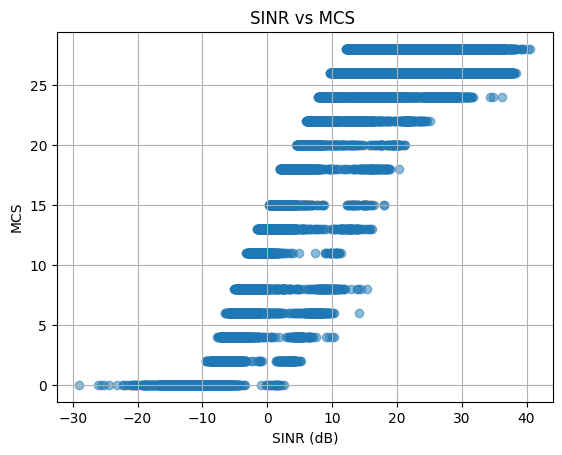

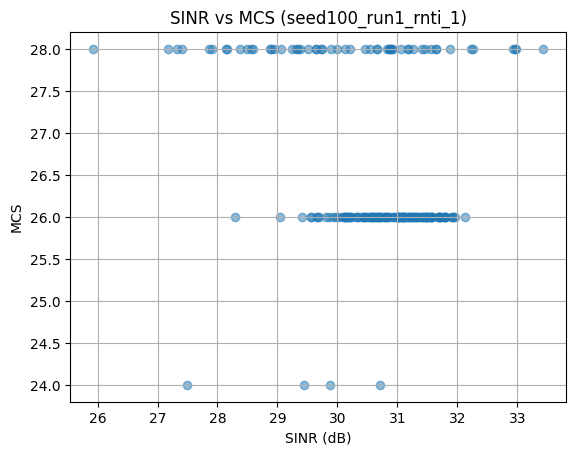

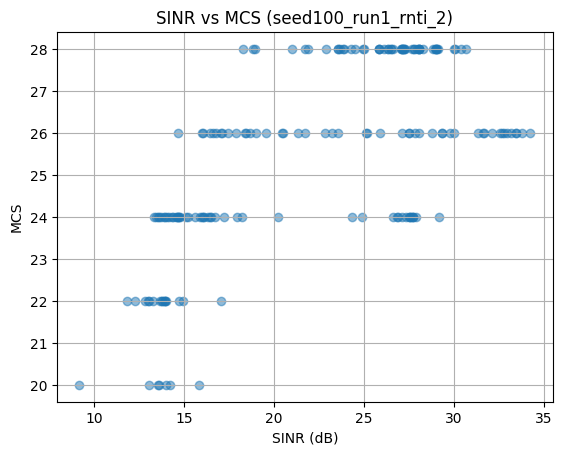

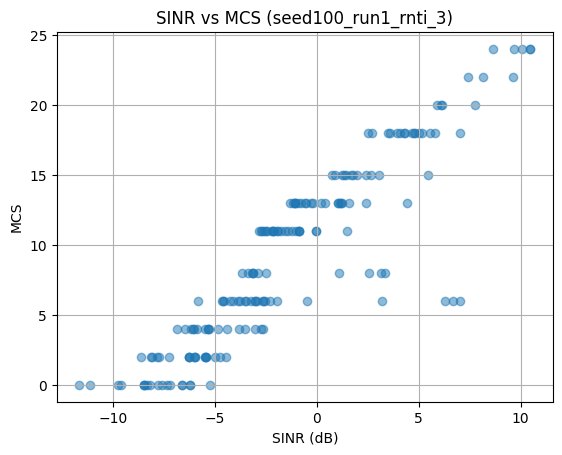

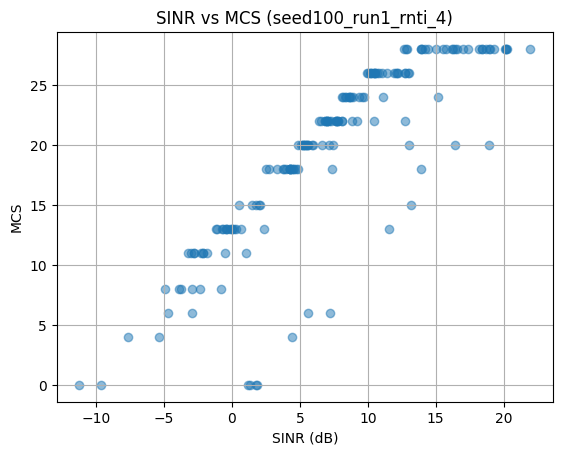

In [ ]:
plot_sinr_vs_mcs(df)
plot_sinr_vs_mcs(df, rnti_filter="seed100_run1_rnti_1")
plot_sinr_vs_mcs(df, rnti_filter="seed100_run1_rnti_2")
plot_sinr_vs_mcs(df, rnti_filter="seed100_run1_rnti_3")
plot_sinr_vs_mcs(df, rnti_filter="seed100_run1_rnti_4")

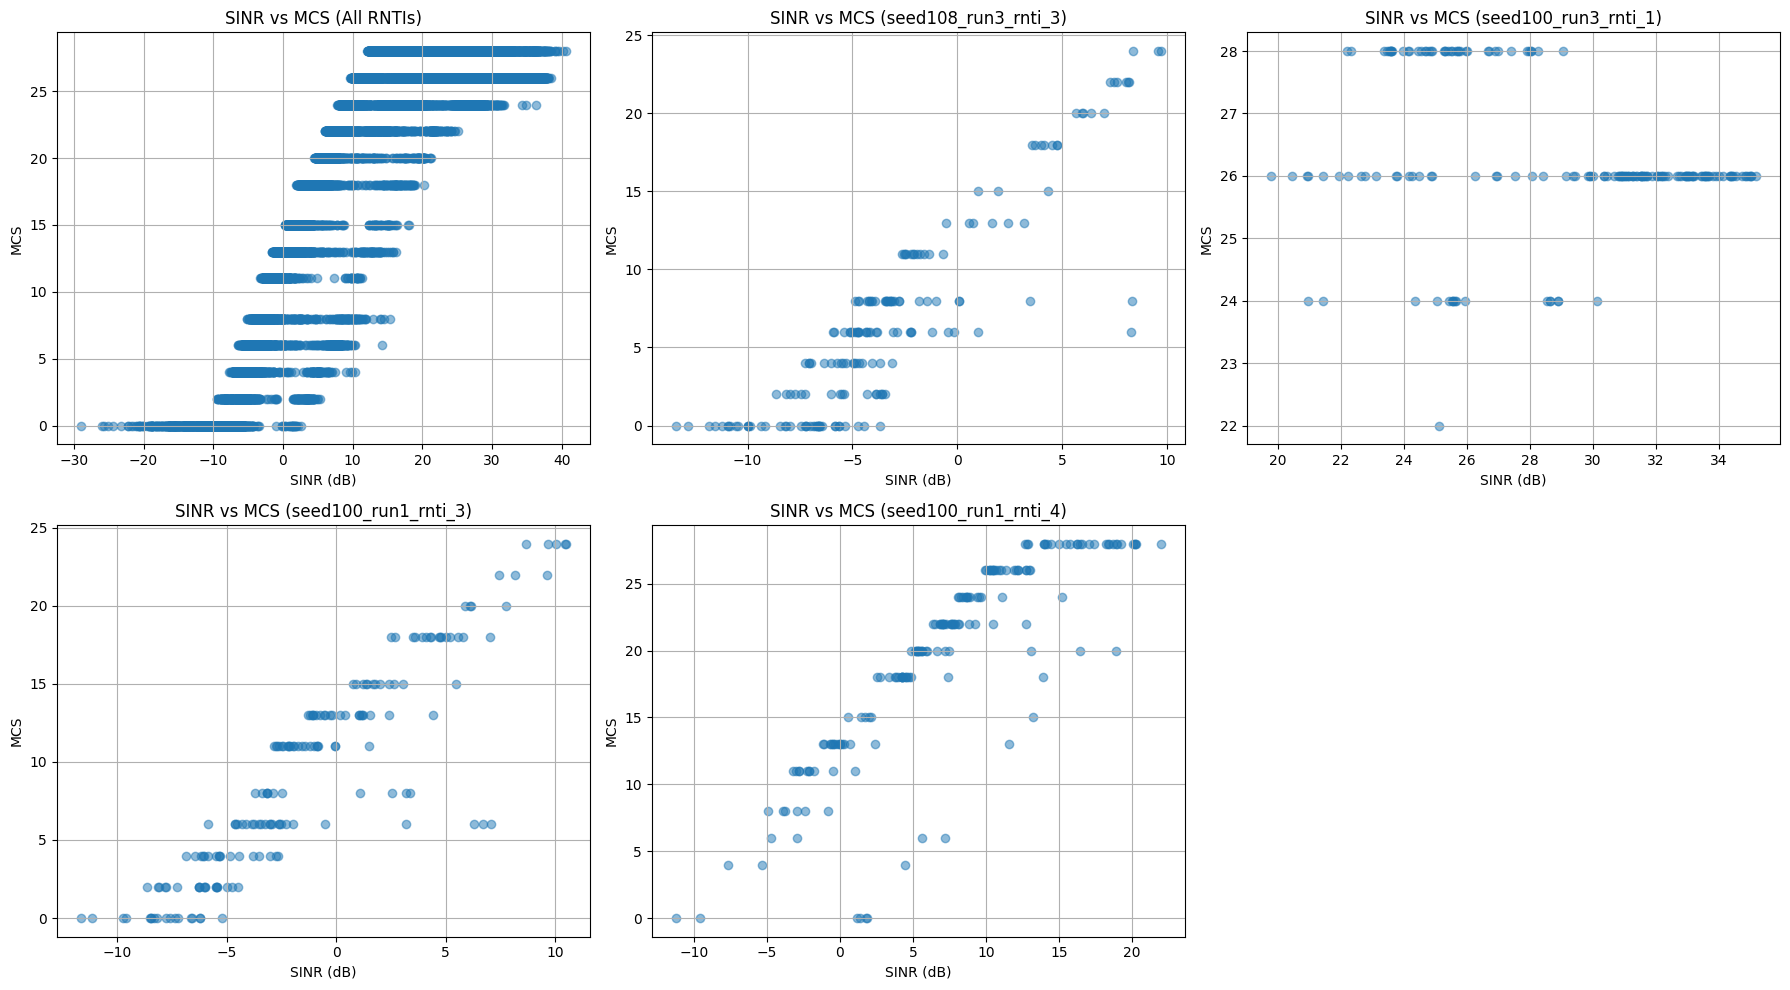

In [ ]:
import matplotlib.pyplot as plt

# List of the four RNTI values you want to plot separately
rnti_list = [
    "seed108_run3_rnti_3",
    "seed100_run3_rnti_1",
    "seed100_run1_rnti_3",
    "seed100_run1_rnti_4"
]

# Create a 2×3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 1) Overall SINR vs MCS (all RNTIs)
axes[0].scatter(df["sinr"], df["mcs"], alpha=0.5)
axes[0].set_xlabel("SINR (dB)")
axes[0].set_ylabel("MCS")
axes[0].set_title("SINR vs MCS (All RNTIs)")
axes[0].grid(True)

# 2) SINR vs MCS for each of the four specified RNTIs
for i, rnti in enumerate(rnti_list, start=1):
    subdf = df[df["RNTI"] == rnti]
    axes[i].scatter(subdf["sinr"], subdf["mcs"], alpha=0.5)
    axes[i].set_xlabel("SINR (dB)")
    axes[i].set_ylabel("MCS")
    axes[i].set_title(f"SINR vs MCS ({rnti})")
    axes[i].grid(True)

# 3) Turn off the unused (sixth) subplot
axes[5].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def plot_cqi_count_over_time(df, rnti_filter=None):
    if rnti_filter:
        df = df[df["RNTI"] == rnti_filter]

    plt.figure()
    plt.plot(df["time"], df["cqi_count"], drawstyle='steps-post')
    plt.xlabel("Time (s)")
    plt.ylabel("CQI Messages Count")
    plt.title(f"CQI Count vs Time {'('+rnti_filter+')' if rnti_filter else ''}")
    plt.grid(True)
    plt.show()


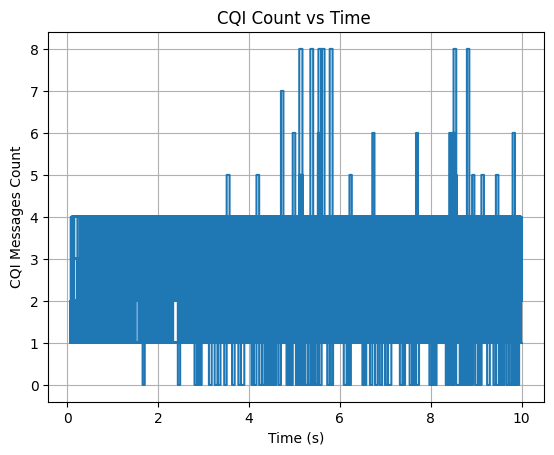

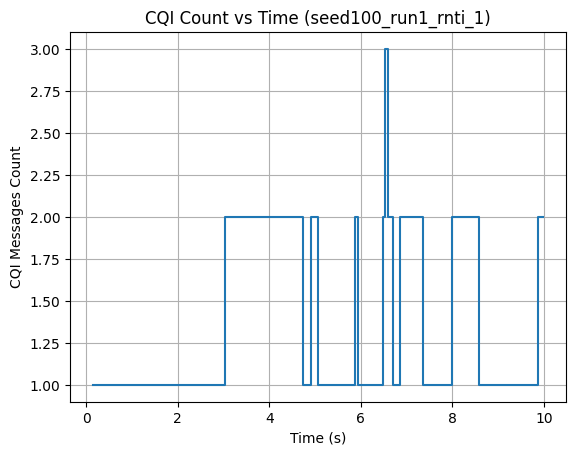

In [ ]:
plot_cqi_count_over_time(df)
plot_cqi_count_over_time(df, rnti_filter="seed100_run1_rnti_1")

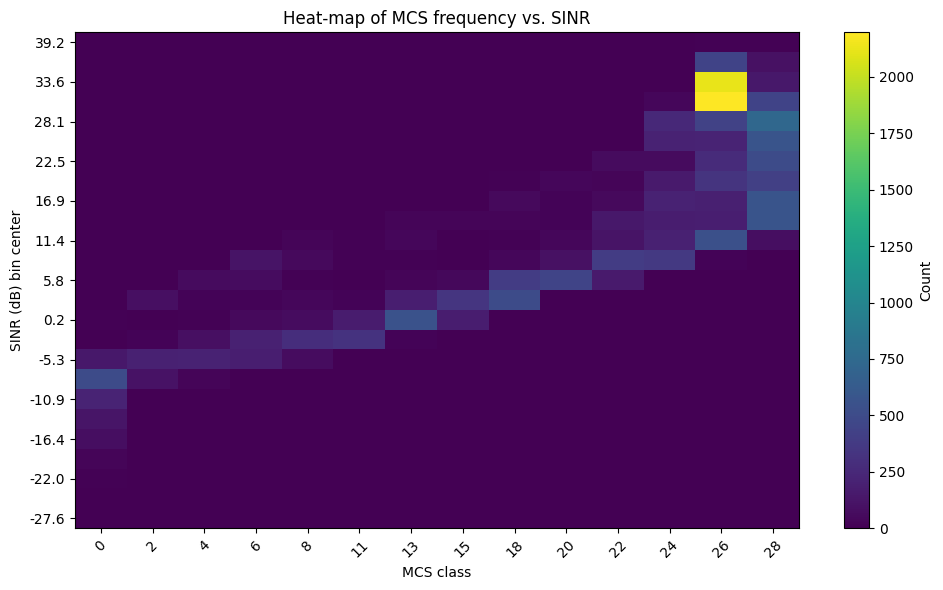

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Decide on your SINR bins. For example, from min to max in df, 25 bins:
num_sinr_bins = 25
sinr_min, sinr_max = df["sinr"].min(), df["sinr"].max()
sinr_bins = np.linspace(sinr_min, sinr_max, num_sinr_bins + 1)

# 2) Use pandas.cut to assign each row to a SINR‐bin index [0..num_sinr_bins-1]
df["sinr_bin"] = pd.cut(df["sinr"], bins=sinr_bins, labels=False, include_lowest=True)

# 3) Create a pivot table (sinr_bin × mcs) counting occurrences
#    Since MCS may not be 0..28 densely, we'll re-index columns for all possible MCS values
all_mcs = np.sort(df["mcs"].unique())
heat_counts = (
    df.groupby(["sinr_bin", "mcs"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=all_mcs, fill_value=0)
      .to_numpy()      # shape = (num_sinr_bins, len(all_mcs))
)

# 4) (Optional) normalize each row (or entire matrix) if you want relative frequencies
#    For row‐wise normalization (so each SINR‐bin sums to 1):
heat_norm = heat_counts / heat_counts.sum(axis=1, keepdims=True)
#    If you prefer raw counts, just use `heat_counts` instead of `heat_norm` below.

# 5) Plot the heat‐map
fig, ax = plt.subplots(figsize=(10, 6))

# Choose which matrix to display:
#   - `heat_counts` for raw counts
#   - `heat_norm`   for normalized frequencies per SINR‐bin
display_matrix = heat_counts   # or heat_norm

# imshow: x‐axis = MCS classes, y‐axis = SINR bins
im = ax.imshow(display_matrix,
               aspect="auto",
               origin="lower",
               cmap="viridis")

# 6) Label ticks:
#   For x‐ticks (MCS), show every few or all classes:
ax.set_xticks(np.arange(len(all_mcs)))
ax.set_xticklabels(all_mcs, rotation=45)

#   For y‐ticks, convert bin index back to human‐readable ranges:
#   We’ll label each tick by the midpoint of its SINR‐bin:
sinr_bin_centers = 0.5 * (sinr_bins[:-1] + sinr_bins[1:])
# Show every, say, 5th label to avoid crowding:
ytick_locs = np.arange(0, num_sinr_bins, max(1, num_sinr_bins // 10))
ytick_labels = [f"{sinr_bin_centers[i]:.1f}" for i in ytick_locs]
ax.set_yticks(ytick_locs)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel("MCS class")
ax.set_ylabel("SINR (dB) bin center")
ax.set_title("Heat‐map of MCS frequency vs. SINR")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Count" if display_matrix is heat_counts else "Frequency")

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    corr_data = df[["mcs", "sinr", "cqi_count"]].dropna()
    corr_matrix = corr_data.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation Heatmap: MCS, SINR, CQI Count")
    plt.tight_layout()
    plt.show()


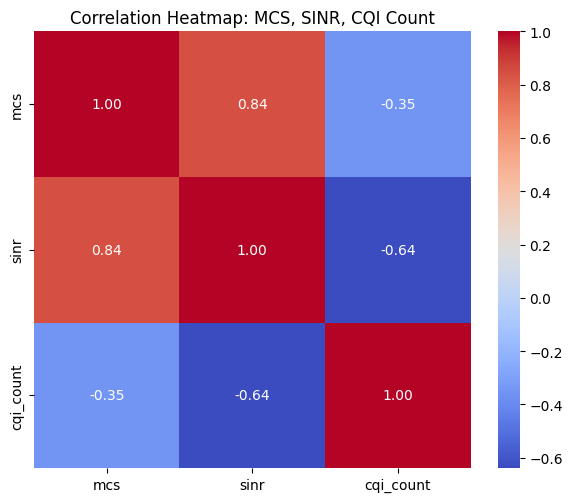

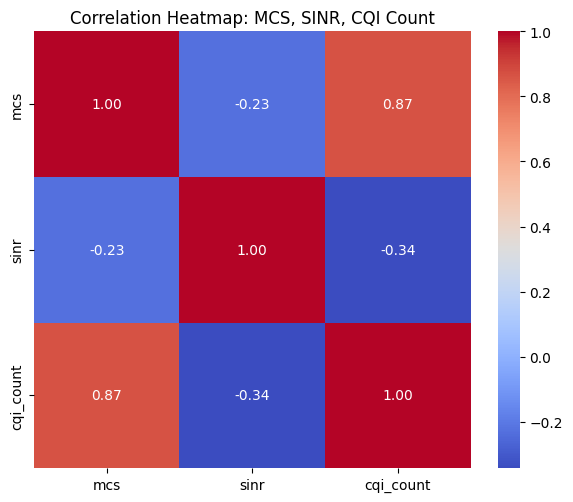

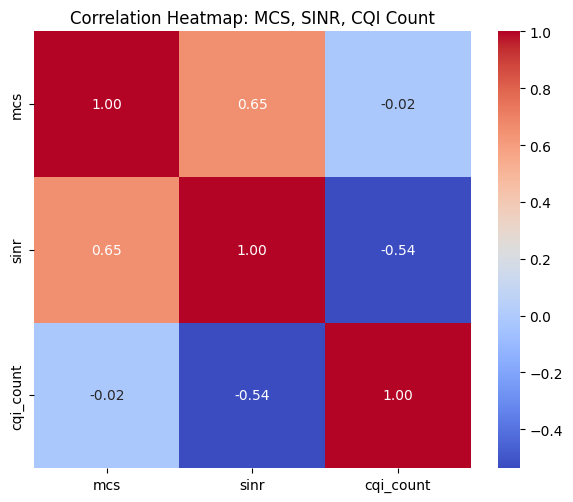

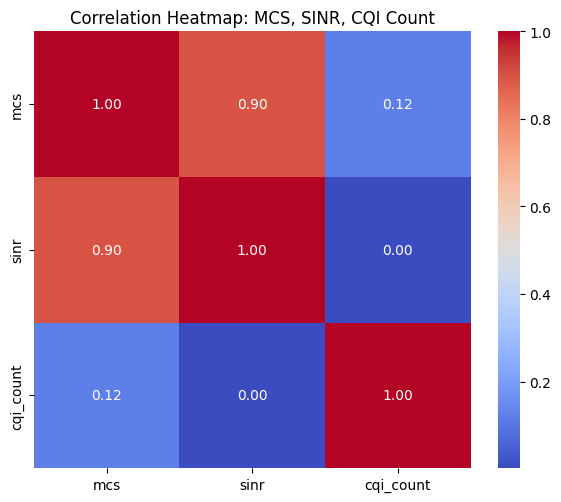

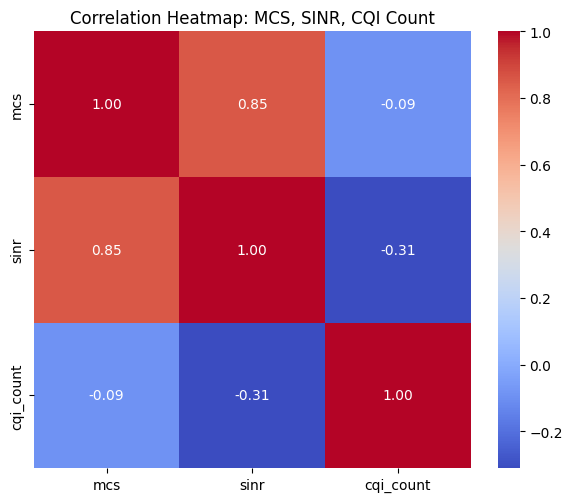

In [ ]:
plot_correlation_heatmap(df)
plot_correlation_heatmap(df[df["RNTI"] == "seed100_run1_rnti_1"])
plot_correlation_heatmap(df[df["RNTI"] == "seed100_run1_rnti_2"])
plot_correlation_heatmap(df[df["RNTI"] == "seed100_run1_rnti_3"])
plot_correlation_heatmap(df[df["RNTI"] == "seed100_run1_rnti_4"])

In [ ]:
def plot_cqi_vs_mcs(df, rnti_filter=None):
    if rnti_filter:
        df = df[df["RNTI"] == rnti_filter]

    df = df.dropna(subset=["mcs", "cqi_count"])

    plt.figure()
    plt.scatter(df["cqi_count"], df["mcs"], alpha=0.5)
    plt.xlabel("CQI Count")
    plt.ylabel("MCS")
    plt.title(f"CQI Count vs MCS {'('+rnti_filter+')' if rnti_filter else ''}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


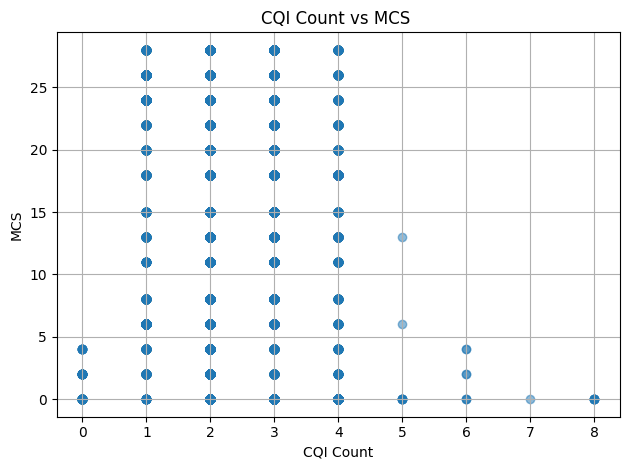

In [ ]:
plot_cqi_vs_mcs(df)


In [ ]:
def plot_mcs_over_time(df, rnti_filter=None):
    if rnti_filter:
        df = df[df["RNTI"] == rnti_filter]

    df = df.dropna(subset=["mcs", "time"]).sort_values("time")

    plt.figure()
    plt.plot(df["time"], df["mcs"], marker='o', linestyle='-', alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("MCS")
    plt.title(f"MCS Over Time {'('+rnti_filter+')' if rnti_filter else ''}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


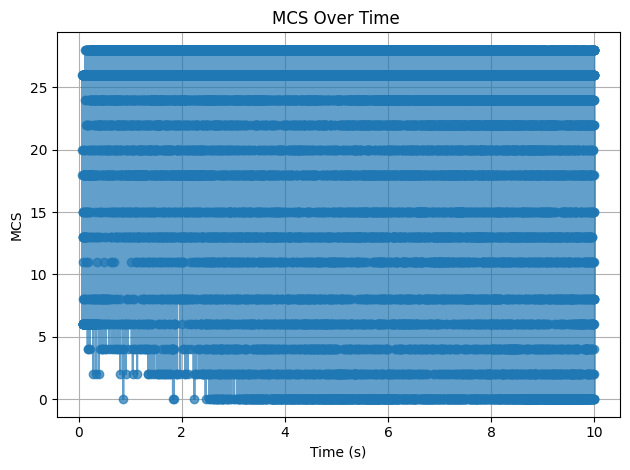

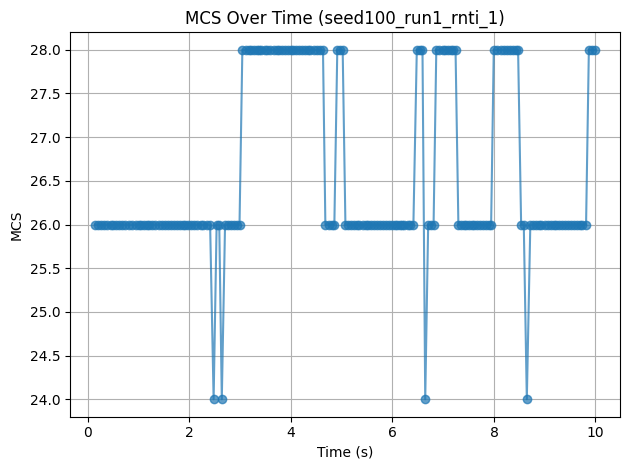

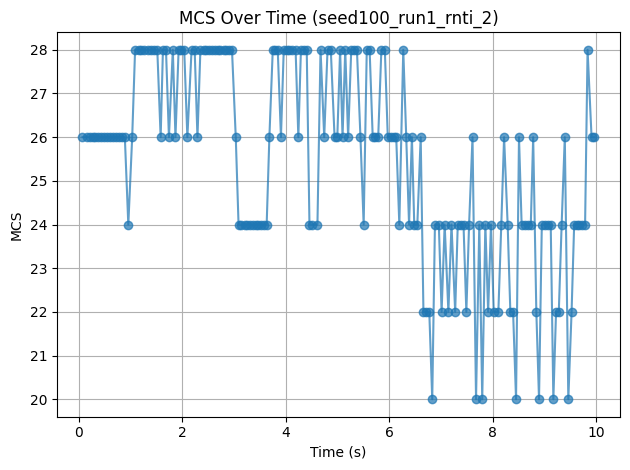

In [ ]:
plot_mcs_over_time(df)
plot_mcs_over_time(df, rnti_filter="seed100_run1_rnti_1")
plot_mcs_over_time(df, rnti_filter="seed100_run1_rnti_2")

## Modelling


### Preprocessing

In [ ]:
print(df.head())
print(df.tail())

     time  mcs     sinr                 RNTI           run  cqi_count  \
0  0.0765   26  33.4369  seed100_run1_rnti_2  seed100_run1        1.0   
1  0.1585   26  32.6890  seed100_run1_rnti_2  seed100_run1        1.0   
2  0.2145   26  33.4499  seed100_run1_rnti_2  seed100_run1        1.0   
3  0.2745   26  33.1776  seed100_run1_rnti_2  seed100_run1        1.0   
4  0.3265   26  34.2603  seed100_run1_rnti_2  seed100_run1        1.0   

   sinr_bin  
0        22  
1        22  
2        22  
3        22  
4        22  
         time  mcs     sinr                 RNTI           run  cqi_count  \
20713  9.6905   26  15.2309  seed109_run3_rnti_2  seed109_run3        2.0   
20714  9.7555   24  15.9378  seed109_run3_rnti_2  seed109_run3        2.0   
20715  9.8265   24  16.7065  seed109_run3_rnti_2  seed109_run3        2.0   
20716  9.8875   22  14.4060  seed109_run3_rnti_2  seed109_run3        2.0   
20717  9.9505   24  16.9206  seed109_run3_rnti_2  seed109_run3        2.0   

       sinr_bi

In [ ]:
df = df.drop(columns=["run"])

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["rnti_encoded"] = le.fit_transform(df["RNTI"])


In [ ]:
df.head()

,time,mcs,sinr,RNTI,cqi_count,sinr_bin,rnti_encoded
0,0.0765,26,33.4369,seed100_run1_rnti_2,1.0,22,1
1,0.1585,26,32.6890,seed100_run1_rnti_2,1.0,22,1
2,0.2145,26,33.4499,seed100_run1_rnti_2,1.0,22,1
3,0.2745,26,33.1776,seed100_run1_rnti_2,1.0,22,1
4,0.3265,26,34.2603,seed100_run1_rnti_2,1.0,22,1


In [ ]:
df = df.dropna(subset=["sinr", "cqi_count", "mcs"])


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["sinr", "cqi_count"]] = scaler.fit_transform(df[["sinr", "cqi_count"]])


In [ ]:
df["mcs"].value_counts()

,count
mcs,
26,6965
28,4132
24,1677
0,1143
18,1030
22,968
13,880
20,674
6,658


In [ ]:
df.head()

,time,mcs,sinr,RNTI,cqi_count,sinr_bin,rnti_encoded
0,0.0765,26,1.238189,seed100_run1_rnti_2,-1.108845,22,1
1,0.1585,26,1.184632,seed100_run1_rnti_2,-1.108845,22,1
2,0.2145,26,1.239120,seed100_run1_rnti_2,-1.108845,22,1
3,0.2745,26,1.219620,seed100_run1_rnti_2,-1.108845,22,1
4,0.3265,26,1.297152,seed100_run1_rnti_2,-1.108845,22,1


In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[["sinr", "cqi_count", "rnti_encoded"]]
y = df["mcs"]

# First split: train + temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# Second split: val and test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

# Print shape summary
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (14502, 3), Val: (3108, 3), Test: (3108, 3)


### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split

# 🏋️ Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# 📈 Predict
y_pred = ridge.predict(X_test)

# 🧮 Round predictions (MCS are discrete values)
y_pred_rounded = np.clip(np.round(y_pred), 0, None)
# 📝 Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("\nClassification Report (rounded):")
print(classification_report(y_test, y_pred_rounded.astype(int)))

R² Score: 0.7775383741927862
MSE: 17.08815280446091

Classification Report (rounded):
              precision    recall  f1-score   support

           0       1.00      0.06      0.11       166
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00        67
           5       0.00      0.00      0.00         0
           6       0.02      0.01      0.01       102
           7       0.00      0.00      0.00         0
           8       0.28      0.21      0.24        99
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.05      0.08      0.06        66
          12       0.00      0.00      0.00         0
          13       0.18      0.11      0.14       146
          14       0.00      0.00      0.00         0
          15       0.17      0.17      0.17      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train.astype(int))
y_pred_clf = clf.predict(X_test)

print(classification_report(y_test.astype(int), y_pred_clf))


              precision    recall  f1-score   support

           0       0.61      0.98      0.75       166
           2       0.11      0.05      0.07        77
           4       0.00      0.00      0.00        67
           6       0.14      0.25      0.18       102
           8       0.50      0.01      0.02        99
          11       0.00      0.00      0.00        66
          13       0.29      0.38      0.33       146
          15       0.00      0.00      0.00        88
          18       0.29      0.67      0.40       142
          20       0.00      0.00      0.00        93
          22       0.28      0.19      0.22       150
          24       0.17      0.11      0.14       253
          26       0.74      0.79      0.76      1039
          28       0.64      0.72      0.68       620

    accuracy                           0.53      3108
   macro avg       0.27      0.30      0.25      3108
weighted avg       0.48      0.53      0.49      3108



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

## HDC MiniRocket

In [ ]:
!pip install sktime numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested

In [ ]:
# Parameters
T = 10
features = ['sinr', 'cqi_count', 'rnti_encoded']
label_col = 'mcs'

# Sliding window creation
X = []
y = []

for i in range(len(df) - T):
    window = df[features].iloc[i:i+T].values
    label = df[label_col].iloc[i+T]
    X.append(window)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Convert to sktime format
X_sktime = from_3d_numpy_to_nested(X)


Train: (14495, 10, 3), Val: (3106, 10, 3), Test: (3107, 10, 3)


In [ ]:
X_train

array([[[ 1.06532361e+00, -1.10884451e+00,  4.00000000e+01],
        [ 1.09656679e+00, -1.10884451e+00,  4.00000000e+01],
        [ 1.09104570e+00, -1.10884451e+00,  4.00000000e+01],
        ...,
        [ 1.07132448e+00, -1.10884451e+00,  4.00000000e+01],
        [ 1.10042653e+00, -1.10884451e+00,  4.00000000e+01],
        [ 1.09745474e+00, -1.10884451e+00,  4.00000000e+01]],

       [[-6.67788178e-01,  6.22933653e-02,  9.50000000e+01],
        [-3.93173352e-01,  6.22933653e-02,  9.50000000e+01],
        [-4.44043226e-01,  2.40456912e+00,  9.50000000e+01],
        ...,
        [-2.70549443e-01,  2.40456912e+00,  9.50000000e+01],
        [-1.24699710e+00,  2.40456912e+00,  9.50000000e+01],
        [-1.24699710e+00, -2.27998239e+00,  9.50000000e+01]],

       [[-1.19610696e+00,  6.22933653e-02,  9.50000000e+01],
        [-8.91440754e-01,  6.22933653e-02,  9.50000000e+01],
        [-9.91360192e-01,  6.22933653e-02,  9.50000000e+01],
        ...,
        [-9.39332394e-01, -1.10884451e+00,

In [ ]:

from imblearn.over_sampling import RandomOverSampler

# Flatten time windows for oversampling
X_flat = X.reshape(X.shape[0], -1)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_flat, y)

# Reshape back to (samples, features, time)
X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2])

In [ ]:
# Reshape (T, features) to (features, T) for each window
X = [window.T for window in X]  # list of arrays (features, T)
X = np.array(X)



In [ ]:

# Convert to sktime format
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested
X_sktime = from_3d_numpy_to_nested(X)

In [ ]:

# First split: train + temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# Second split: val and test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

# Print shape summary
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (14495, 3, 10), Val: (3106, 3, 10), Test: (3107, 3, 10)


In [ ]:
# Build pipeline
pipe = make_pipeline(
    MiniRocketMultivariate(),
    RidgeClassifierCV()
)

# Train and evaluate
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print(f"MiniROCKET + Ridge Accuracy: {score:.4f}")


ValueError: n_timepoints must be >= 9, but found 3; zero pad shorter series so that n_timepoints == 9

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.93      0.64       152
           2       0.38      0.08      0.13        66
           4       0.20      0.06      0.09        54
           6       0.22      0.11      0.14       102
           8       0.14      0.07      0.09        86
          11       0.15      0.08      0.11        83
          13       0.21      0.22      0.22       136
          15       0.07      0.03      0.04        97
          18       0.23      0.29      0.26       151
          20       0.10      0.05      0.06        87
          22       0.24      0.14      0.17       155
          24       0.38      0.23      0.29       261
          26       0.73      0.79      0.76      1054
          28       0.57      0.77      0.66       623

    accuracy                           0.53      3107
   macro avg       0.29      0.27      0.26      3107
weighted avg       0.48      0.53      0.49      3107



### HDC MiniRocket

In [ ]:
!git clone https://github.com/TUC-ProAut/HDC_MiniROCKET.git
%cd HDC_MiniROCKET

Cloning into 'HDC_MiniROCKET'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 55 (delta 19), reused 46 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 117.93 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/HDC_MiniROCKET


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Parameters
T = 10  # sequence length
features = ['sinr', 'cqi_count', 'rnti_encoded']
label_col = 'mcs'

# Sliding window
X = []
y = []

for i in range(len(df) - T):
    window = df[features].iloc[i:i+T].values.flatten()
    label = df[label_col].iloc[i+T]
    X.append(window)
    y.append(label)

X = np.array(X)
y = np.array(y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (16566, 30), Test: (4142, 30)


In [ ]:
import os

# Path to UCR-style folder
dataset_name = "My5GData"
folder_path = f"data/{dataset_name}"
os.makedirs(folder_path, exist_ok=True)

def write_ts_file(X, y, file_path):
    with open(file_path, 'w') as f:
        f.write("@problemName " + dataset_name + "\n")
        f.write("@timeStamps false\n")
        f.write("@univariate false\n")
        f.write("@classLabel true " + " ".join(map(str, sorted(set(y)))) + "\n")
        f.write("@data\n")
        for xi, yi in zip(X, y):
            series = ":".join(map(str, xi))
            f.write(f"{yi}    {series}\n")

# Write train and test
write_ts_file(X_train, y_train, f"{folder_path}/{dataset_name}_TRAIN.ts")
write_ts_file(X_test, y_test, f"{folder_path}/{dataset_name}_TEST.ts")


In [ ]:
!python main.py --dataset UCR --ensemble_idx 0 --model HDC_MINIROCKET


Loading UCR train / test dataset :  /Univariate_tsACSF1
Traceback (most recent call last):
  File "/content/HDC_MiniROCKET/main.py", line 72, in <module>
    trainer = NetTrial(args)
              ^^^^^^^^^^^^^^
  File "/content/HDC_MiniROCKET/main_run.py", line 33, in __init__
    self.load_data()
  File "/content/HDC_MiniROCKET/main_run.py", line 37, in load_data
    self.data = load_dataset(self.config.dataset, self.config)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/HDC_MiniROCKET/data/dataset_utils.py", line 28, in load_dataset
    X_train, X_test, y_train, y_test = load_UCR_dataset(ucr_index=config.ensemble_idx,
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/HDC_MiniROCKET/data/dataset_utils.py", line 63, in load_UCR_dataset
    X_train, y_train = load_UCR_UEA_dataset(name=UCR_PREFIX[ucr_index],
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib

## CNN based classifier


### CNN wth just SINR

In [ ]:
import pandas as pd
import numpy as np

# Set your sequence length
T = 10


In [ ]:
def create_sliding_windows(df, window_size):
    X = []          # input sequences of SINR
    y_class = []    # output MCS labels

    grouped = df.groupby('rnti_encoded')

    for _, group in grouped:
        group = group.sort_values('time').reset_index(drop=True)

        for i in range(len(group) - window_size):
            sinr_seq = group['sinr'].iloc[i:i+window_size].values
            mcs_label = group['mcs'].iloc[i + window_size]  # the "next" MCS

            # Only if all values are valid
            if not np.isnan(sinr_seq).any() and not pd.isnull(mcs_label):
                X.append(sinr_seq)
                y_class.append(mcs_label)

    return np.array(X), np.array(y_class)


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1]))
    return X_scaled.reshape(X.shape), scaler


In [ ]:
df["mcs"].value_counts()

,count
mcs,
26,6965
28,4132
24,1677
0,1143
18,1030
22,968
13,880
20,674
6,658


In [ ]:
# Load your CSV or use existing df
# df = pd.read_csv('your_data.csv')

X_raw, y_raw = create_sliding_windows(df, T)
X_scaled, scaler = normalize_features(X_raw)

print("X shape:", X_scaled.shape)  # (samples, T)
print("y shape:", y_raw.shape)     # (samples,)


X shape: (19518, 10)
y shape: (19518,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MCSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B, 1, T)
        self.y = torch.tensor(y, dtype=torch.long)  # for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Count how many times each MCS appears
class_counts = np.bincount(y_train)

class_weights = np.zeros_like(class_counts, dtype=np.float64)
nonzero_mask = class_counts != 0
class_weights[nonzero_mask] = 1. / class_counts[nonzero_mask]

# Create a weight for each sample in training set
sample_weights = class_weights[y_train]
sample_weights_tensor = torch.DoubleTensor(sample_weights)


In [ ]:
sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_raw, test_size=0.2, random_state=42)

train_dataset = MCSDataset(X_train, y_train)
val_dataset = MCSDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNMCSClassifier(nn.Module):
    def __init__(self, input_length=10, num_classes=29):  # adjust num_classes as needed
        super(CNNMCSClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * input_length, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNMCSClassifier(input_length=10, num_classes=29).to(device)

#### Training

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNMCSClassifier(input_length=10, num_classes=29).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

best_val_acc = 0.0
num_epochs = 50  # increase this as needed

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 🔍 Validation after epoch
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            _, val_preds = torch.max(val_outputs, 1)
            correct += (val_preds == y_val_batch).sum().item()
            total += y_val_batch.size(0)

    val_acc = correct / total

    print(f"Epoch {epoch}, Train Loss: {total_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mcs_cnn.pth")



Epoch 1, Train Loss: 356.5484, Val Accuracy: 47.80%
Epoch 2, Train Loss: 334.6913, Val Accuracy: 49.97%
Epoch 3, Train Loss: 326.4583, Val Accuracy: 50.59%
Epoch 4, Train Loss: 325.0905, Val Accuracy: 49.00%
Epoch 5, Train Loss: 321.7307, Val Accuracy: 50.28%
Epoch 6, Train Loss: 321.0409, Val Accuracy: 50.18%
Epoch 7, Train Loss: 317.3427, Val Accuracy: 50.26%
Epoch 8, Train Loss: 316.3940, Val Accuracy: 50.23%
Epoch 9, Train Loss: 315.8701, Val Accuracy: 51.36%
Epoch 10, Train Loss: 314.5444, Val Accuracy: 50.72%
Epoch 11, Train Loss: 312.5137, Val Accuracy: 50.59%
Epoch 12, Train Loss: 312.1925, Val Accuracy: 50.67%
Epoch 13, Train Loss: 311.0372, Val Accuracy: 50.46%
Epoch 14, Train Loss: 311.7188, Val Accuracy: 50.59%
Epoch 15, Train Loss: 310.5241, Val Accuracy: 50.56%
Epoch 16, Train Loss: 309.5720, Val Accuracy: 51.36%
Epoch 17, Train Loss: 308.7930, Val Accuracy: 50.31%
Epoch 18, Train Loss: 307.8644, Val Accuracy: 50.92%
Epoch 19, Train Loss: 307.2182, Val Accuracy: 51.08%
Ep

#### Evaluation

In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    return all_preds, all_labels


In [ ]:
preds, labels = evaluate(model, val_loader, device)


Validation Accuracy: 51.46%


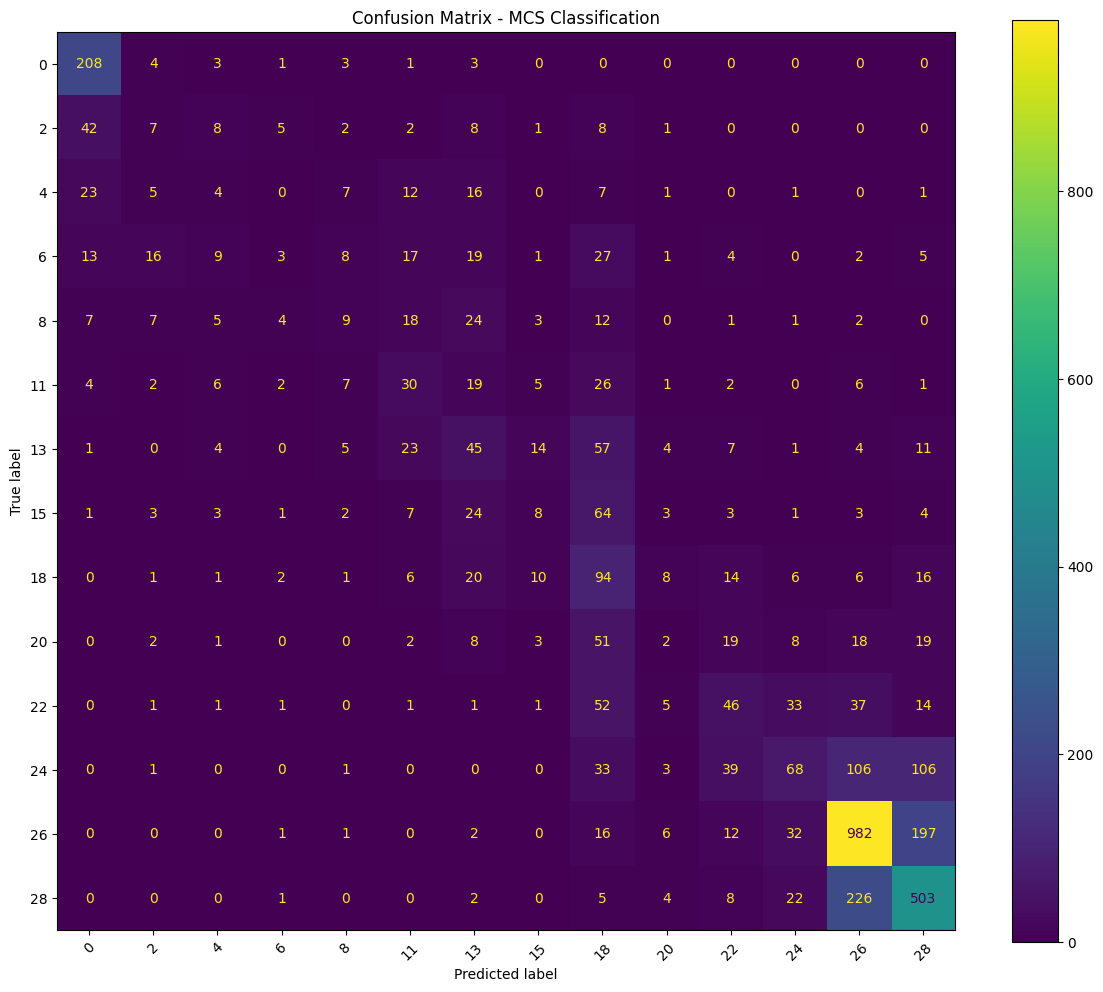

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds, labels=sorted(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(set(labels)))

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='viridis', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - MCS Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

cm_sinr = cm.copy()

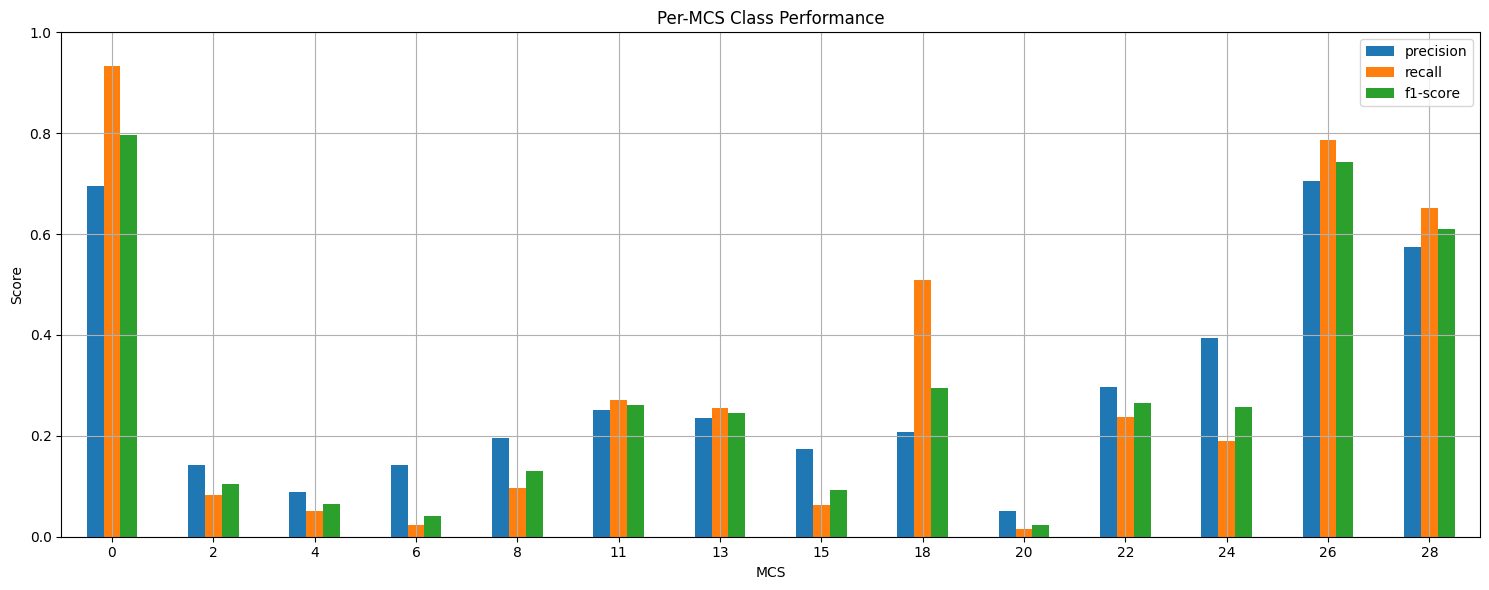

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display only actual MCS classes
df_report_filtered = df_report.loc[df_report.index.str.isnumeric()]
import matplotlib.pyplot as plt

df_report_filtered[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Per-MCS Class Performance")
plt.xlabel("MCS")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

cp_sinr = df_report_filtered.copy()

### CNN with SINR and CQI


In [ ]:
T=10

In [ ]:
def create_multivariate_windows(df, window_size):
    X = []
    y = []

    grouped = df.groupby('rnti_encoded')

    for _, group in grouped:
        group = group.sort_values('time').reset_index(drop=True)

        for i in range(len(group) - window_size):
            features = group[['sinr', 'cqi_count']].iloc[i:i+window_size].values.T  # shape: (2, T)
            target = group['mcs'].iloc[i + window_size]

            if not np.isnan(features).any() and not pd.isnull(target):
                X.append(features)
                y.append(target)

    return np.array(X), np.array(y)


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_multivariate(X):
    n_features = X.shape[1]
    T = X.shape[2]
    X_scaled = np.empty_like(X)

    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()
        X_scaled[:, i, :] = scaler.fit_transform(X[:, i, :])
        scalers.append(scaler)

    return X_scaled, scalers


In [ ]:
X_raw, y_raw = create_multivariate_windows(df, T)
X_scaled, scalers = normalize_multivariate(X_raw)

# Dataset class remains the same (but now inputs are [B, 2, 10])
class MCSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Count how many times each MCS appears
class_counts = np.bincount(y_train)

class_weights = np.zeros_like(class_counts, dtype=np.float64)
nonzero_mask = class_counts != 0
class_weights[nonzero_mask] = 1. / class_counts[nonzero_mask]

# Create a weight for each sample in training set
sample_weights = class_weights[y_train]
sample_weights_tensor = torch.DoubleTensor(sample_weights)

In [ ]:
class CNNMCSClassifier(nn.Module):
    def __init__(self, input_length=10, in_channels=2, num_classes=29):
        super(CNNMCSClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * input_length, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_raw, test_size=0.2, random_state=42)

train_dataset = MCSDataset(X_train, y_train)
val_dataset = MCSDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

#### Training

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNMCSClassifier(input_length=10, num_classes=29).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

best_val_acc = 0.0
num_epochs = 50  # increase this as needed

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 🔍 Validation after epoch
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            _, val_preds = torch.max(val_outputs, 1)
            correct += (val_preds == y_val_batch).sum().item()
            total += y_val_batch.size(0)

    val_acc = correct / total

    print(f"Epoch {epoch}, Train Loss: {total_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mcs_cnn.pth")



Epoch 1, Train Loss: 341.1031, Val Accuracy: 51.56%
Epoch 2, Train Loss: 313.2614, Val Accuracy: 52.87%
Epoch 3, Train Loss: 304.9663, Val Accuracy: 54.05%
Epoch 4, Train Loss: 301.1610, Val Accuracy: 53.87%
Epoch 5, Train Loss: 297.2261, Val Accuracy: 54.41%
Epoch 6, Train Loss: 293.3563, Val Accuracy: 53.66%
Epoch 7, Train Loss: 291.8427, Val Accuracy: 53.79%
Epoch 8, Train Loss: 289.3643, Val Accuracy: 54.00%
Epoch 9, Train Loss: 288.1245, Val Accuracy: 54.18%
Epoch 10, Train Loss: 287.0002, Val Accuracy: 54.15%
Epoch 11, Train Loss: 285.3747, Val Accuracy: 54.00%
Epoch 12, Train Loss: 284.5569, Val Accuracy: 54.43%
Epoch 13, Train Loss: 283.3118, Val Accuracy: 54.05%
Epoch 14, Train Loss: 281.6548, Val Accuracy: 54.12%
Epoch 15, Train Loss: 281.1862, Val Accuracy: 54.00%
Epoch 16, Train Loss: 280.3975, Val Accuracy: 54.07%
Epoch 17, Train Loss: 279.6789, Val Accuracy: 54.59%
Epoch 18, Train Loss: 277.4346, Val Accuracy: 54.23%
Epoch 19, Train Loss: 277.4752, Val Accuracy: 54.15%
Ep

#### Evaluation

In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    return all_preds, all_labels


In [ ]:
preds, labels = evaluate(model, val_loader, device)


Validation Accuracy: 53.71%


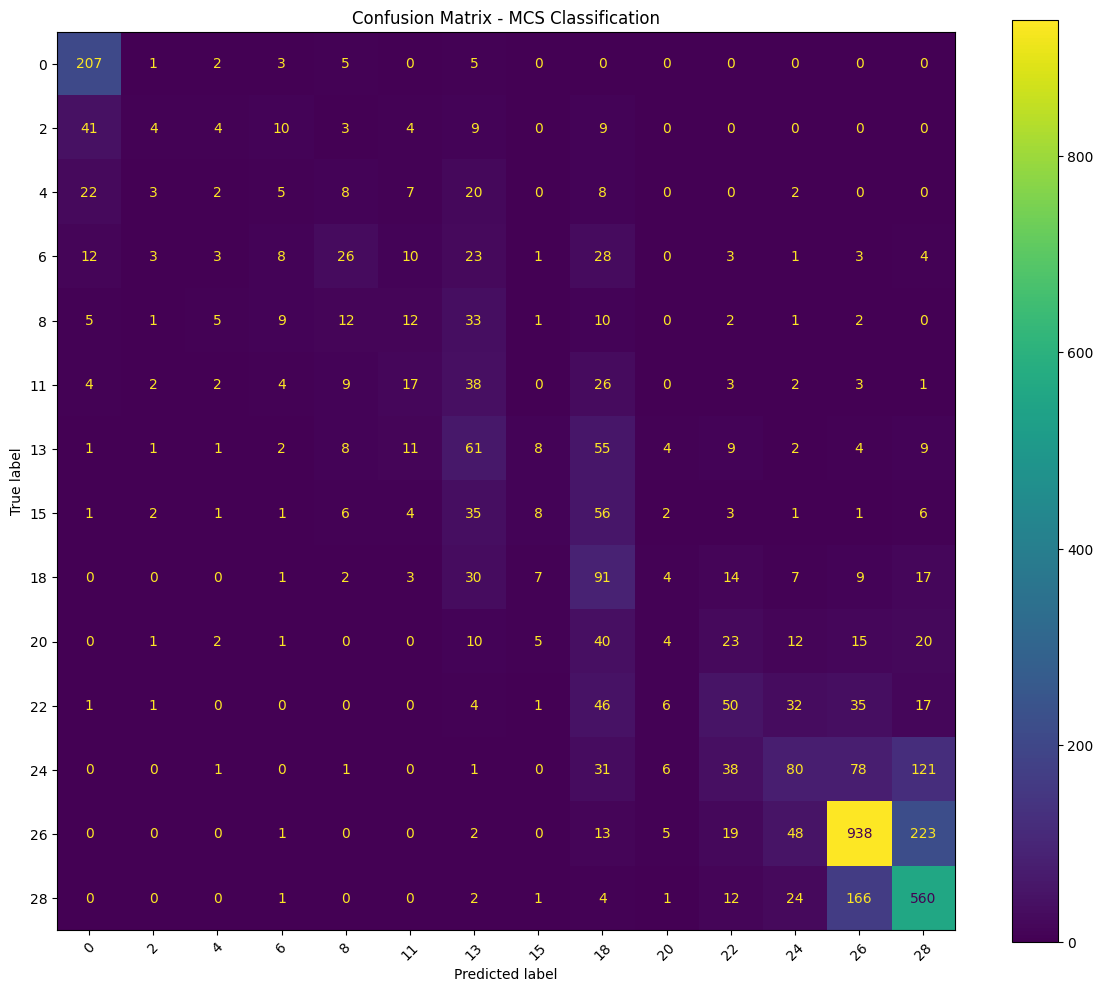

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds, labels=sorted(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(set(labels)))

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='viridis', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - MCS Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

cm_cqi = cm.copy()

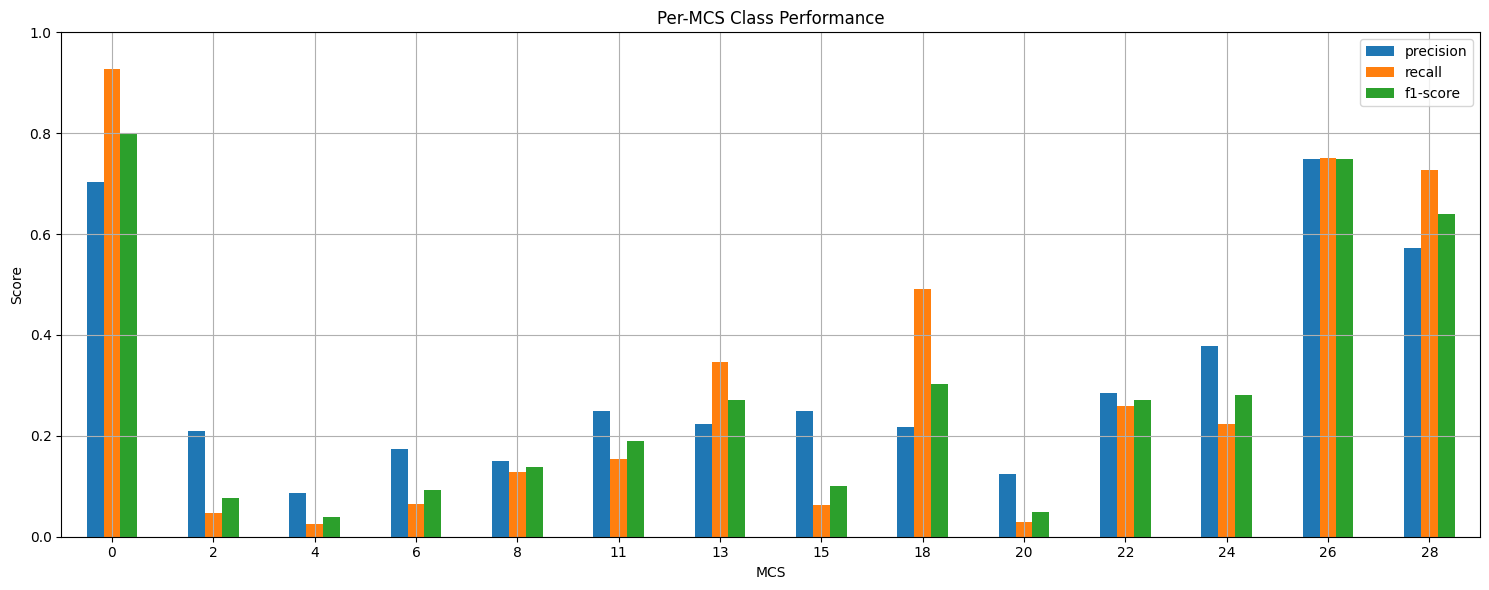

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display only actual MCS classes
df_report_filtered = df_report.loc[df_report.index.str.isnumeric()]
import matplotlib.pyplot as plt

df_report_filtered[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Per-MCS Class Performance")
plt.xlabel("MCS")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

cp_cqi = df_report_filtered.copy()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [ ]:
y_pred, y_true = evaluate(model, val_loader, device)

Validation Accuracy: 53.71%


In [ ]:
mcs_to_se = {
     0: 0.1523,
     1: 0.2344,
     2: 0.3770,
     3: 0.6016,
     4: 0.8770,
     5: 1.1758,
     6: 1.4766,
     7: 1.9141,
     8: 2.4063,
     9: 2.7305,
    10: 3.3223,
    11: 3.9023,
    12: 4.5234,
    13: 5.1152,
    14: 5.5547,
    15: 6.2266,
    16: 6.9141,
    17: 7.4063,
    18: 7.9141,
    19: 8.4063,
    20: 8.9141,
    21: 9.4063,
    22: 9.9141,
    23: 10.4063,
    24: 10.9141,
    25: 11.4063,
    26: 11.9141,
    27: 12.4063,
    28: 12.9141,
}

In [ ]:
import numpy as np

bandwidth = 100e6  # 100 MHz in Hz

# Map to SE
def mcs_to_throughput(mcs_array):
    se_array = np.array([mcs_to_se.get(m, 0) for m in mcs_array])
    return bandwidth * se_array / 1e6  # in Mbps

# Convert to Mbps
true_throughput = mcs_to_throughput(y_true)
pred_throughput = mcs_to_throughput(y_pred)

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_throughput, pred_throughput)
rmse = mean_squared_error(true_throughput, pred_throughput)

print(f"🔹 Mean Absolute Error (Throughput): {mae:.2f} Mbps")
print(f"🔹 RMSE (Throughput): {rmse:.2f} Mbps")


🔹 Mean Absolute Error (Throughput): 96.26 Mbps
🔹 RMSE (Throughput): 33012.65 Mbps


In [ ]:
print("y_pred unique:", sorted(set(y_pred)))
print("y_true unique:", sorted(set(y_true)))


y_pred unique: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(11), np.int64(13), np.int64(15), np.int64(18), np.int64(20), np.int64(22), np.int64(24), np.int64(26), np.int64(28)]
y_true unique: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(11), np.int64(13), np.int64(15), np.int64(18), np.int64(20), np.int64(22), np.int64(24), np.int64(26), np.int64(28)]


### CNN with Masking

In [ ]:
T=10

In [ ]:
class MCSDataset(Dataset):
    def __init__(self, X, y, rnti_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.rnti_ids = torch.tensor(rnti_ids, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.rnti_ids[idx]


In [ ]:
def create_multivariate_windows(df, window_size):
    X = []
    y = []
    rnti_ids = []

    grouped = df.groupby('rnti_encoded')

    for rnti_id, group in grouped:
        group = group.sort_values('time').reset_index(drop=True)

        for i in range(len(group) - window_size):
            features = group[['sinr', 'cqi_count']].iloc[i:i+window_size].values.T
            target = group['mcs'].iloc[i + window_size]

            if not np.isnan(features).any() and not pd.isnull(target):
                X.append(features)
                y.append(target)
                rnti_ids.append(rnti_id)

    return np.array(X), np.array(y), np.array(rnti_ids)


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_multivariate(X):
    n_features = X.shape[1]
    T = X.shape[2]
    X_scaled = np.empty_like(X)

    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()
        X_scaled[:, i, :] = scaler.fit_transform(X[:, i, :])
        scalers.append(scaler)

    return X_scaled, scalers


In [ ]:
X_raw, y_raw, rnti_raw = create_multivariate_windows(df, T)
X_scaled, scalers = normalize_multivariate(X_raw)


In [ ]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Count how many times each MCS appears
class_counts = np.bincount(y_train)

class_weights = np.zeros_like(class_counts, dtype=np.float64)
nonzero_mask = class_counts != 0
class_weights[nonzero_mask] = 1. / class_counts[nonzero_mask]

# Create a weight for each sample in training set
sample_weights = class_weights[y_train]
sample_weights_tensor = torch.DoubleTensor(sample_weights)

In [ ]:
class CNNMCSClassifier(nn.Module):
    def __init__(self, input_length=10, in_channels=2, num_classes=29, num_rntis=100, rnti_emb_dim=8):
        super(CNNMCSClassifier, self).__init__()

        self.rnti_embedding = nn.Embedding(
            num_embeddings = num_rntis + 1,   # real IDs are 0..(num_rntis-1); index num_rntis maps to “unknown”
            embedding_dim   = rnti_emb_dim
        )

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(64 * input_length + rnti_emb_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x, rnti_idx):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)

        rnti_embed = self.rnti_embedding(rnti_idx)
        combined = torch.cat((x, rnti_embed), dim=1)

        out = self.relu(self.fc1(combined))
        return self.fc2(out)


In [ ]:
print("Max rnti_encoded:", rnti_raw.max())
print("Min rnti_encoded:", rnti_raw.min())


Max rnti_encoded: 119
Min rnti_encoded: 0


In [ ]:
num_rntis   = df['rnti_encoded'].nunique()   # e.g., 162, 204, whatever

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_rntis = df['rnti_encoded'].nunique()  # e.g. 200
model = CNNMCSClassifier(
    input_length=10,
    in_channels=2,
    num_classes=29,
    num_rntis=num_rntis,   # embedding will be of size (200 + 1)
    rnti_emb_dim=8
).to(device)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, rnti_train, rnti_val = train_test_split(
    X_scaled, y_raw, rnti_raw, test_size=0.2, random_state=42
)

train_dataset = MCSDataset(X_train, y_train, rnti_train)
val_dataset = MCSDataset(X_val, y_val, rnti_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
print(">>> y_train unique values  =", np.unique(y_train))
print(">>> y_train min, max       =", y_train.min(), y_train.max())
print(">>> Any NaNs in y_train?   =", np.isnan(y_train).any())

print(">>> y_val unique values    =", np.unique(y_val))
print(">>> y_val min, max         =", y_val.min(), y_val.max())
print(">>> Any NaNs in y_val?     =", np.isnan(y_val).any())


>>> y_train unique values  = [ 0  2  4  6  8 11 13 15 18 20 22 24 26 28]
>>> y_train min, max       = 0 28
>>> Any NaNs in y_train?   = False
>>> y_val unique values    = [ 0  2  4  6  8 11 13 15 18 20 22 24 26 28]
>>> y_val min, max         = 0 28
>>> Any NaNs in y_val?     = False


#### Training

In [ ]:
import torch.optim as optim



In [ ]:
unknown_rnti_idx = num_rntis   # the “+1”th embedding row for “unknown”
mask_prob = 0.3                # e.g. 30% of the time we hide the true RNTI


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

best_val_acc = 0.0
num_epochs = 50  # increase this as needed

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch, rnti_batch in train_loader:
        Xb = X_batch.to(device)       # (B, 2, T)
        Yb = y_batch.to(device)       # (B,)
        Rb = rnti_batch.to(device)    # (B,)

        # ───── Step A: create random mask for each sample in this batch ─────
        rand_vals = torch.rand(Rb.shape, device=device)
        Rb_masked = Rb.clone()
        # Wherever rand_vals < 0.3, set that index to “unknown_rnti_idx”
        Rb_masked[rand_vals < mask_prob] = unknown_rnti_idx

        # ───── Step B: forward/backward using masked RNTI indices ─────
        optimizer.zero_grad()
        outputs = model(Xb, Rb_masked)  # <— pass in Rb_masked instead of Rb
        loss    = criterion(outputs, Yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


     # At this point, total_loss is the sum of all batch‐losses.
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Train Loss: {avg_loss:.4f}", end="  ")


    # 🔍 Validation after epoch
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        with torch.no_grad():
            for Xv, Yv, Rv in val_loader:
                Xv = Xv.to(device)
                Yv = Yv.to(device)
                Rv = Rv.to(device)

                val_outputs = model(Xv, Rv)
                _, val_preds = torch.max(val_outputs, 1)
                correct += (val_preds == Yv).sum().item()
                total   += Yv.size(0)


    val_acc = correct / total

    print(f"Epoch {epoch}, Train Loss: {total_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mcs_cnn.pth")



Epoch 1, Train Loss: 1.4095  Epoch 1, Train Loss: 343.9090, Val Accuracy: 53.46%
Epoch 2, Train Loss: 1.2656  Epoch 2, Train Loss: 308.8177, Val Accuracy: 54.05%
Epoch 3, Train Loss: 1.2318  Epoch 3, Train Loss: 300.5638, Val Accuracy: 54.71%
Epoch 4, Train Loss: 1.2083  Epoch 4, Train Loss: 294.8366, Val Accuracy: 54.64%
Epoch 5, Train Loss: 1.1932  Epoch 5, Train Loss: 291.1488, Val Accuracy: 55.05%
Epoch 6, Train Loss: 1.1805  Epoch 6, Train Loss: 288.0484, Val Accuracy: 55.30%
Epoch 7, Train Loss: 1.1672  Epoch 7, Train Loss: 284.7872, Val Accuracy: 54.79%
Epoch 8, Train Loss: 1.1555  Epoch 8, Train Loss: 281.9338, Val Accuracy: 55.40%
Epoch 9, Train Loss: 1.1498  Epoch 9, Train Loss: 280.5454, Val Accuracy: 56.15%
Epoch 10, Train Loss: 1.1398  Epoch 10, Train Loss: 278.1181, Val Accuracy: 55.25%
Epoch 11, Train Loss: 1.1326  Epoch 11, Train Loss: 276.3631, Val Accuracy: 55.64%
Epoch 12, Train Loss: 1.1245  Epoch 12, Train Loss: 274.3772, Val Accuracy: 55.58%
Epoch 13, Train Loss: 

#### Evaluation

In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # If each batch is only (X_batch, y_batch), unpack accordingly:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # If your model no longer needs rnti, just do:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    return all_preds, all_labels


In [ ]:
preds, labels = evaluate(model, val_loader, device)


ValueError: too many values to unpack (expected 2)

In [ ]:
print(type(preds))
print(type(labels))

In [ ]:
classification_report = classification_report(labels, preds)
print(classification_report)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds, labels=sorted(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(set(labels)))

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='viridis', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - MCS Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

cm_mask = cm.copy()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display only actual MCS classes
df_report_filtered = df_report.loc[df_report.index.str.isnumeric()]
import matplotlib.pyplot as plt

df_report_filtered[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Per-MCS Class Performance")
plt.xlabel("MCS")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

cp_mask = df_report_filtered.copy()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ──────────────────────────────────────────────────────────────────────────────
# Assume you already have:
#   CM_SINR, CM_CQI, CM_mask        ←  confusion matrix arrays (numpy)
#   CP_SINR, CP_CQI, CP_mask        ←  pandas DataFrames indexed by MCS class,
#                                      with columns like ['precision','recall','f1-score']
# ──────────────────────────────────────────────────────────────────────────────

# Create a 2×3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(180, 120))
axes = axes.flatten()

# ──────────────────────────────────────────────────────────────────────────────
# Row 1: Confusion Matrices
# ──────────────────────────────────────────────────────────────────────────────

# 1) CM_SINR
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sinr,
                              display_labels=sorted(set(np.arange(cm_sinr.shape[0]))))
disp.plot(ax=axes[0], cmap="viridis", xticks_rotation=45)
axes[0].set_title("Confusion Matrix – SINR‐only")

# 2) CM_CQI
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cqi,
                              display_labels=sorted(set(np.arange(cm_cqi.shape[0]))))
disp.plot(ax=axes[1], cmap="viridis", xticks_rotation=45)
axes[1].set_title("Confusion Matrix – SINR+CQI")

# 3) CM_mask
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mask,
                              display_labels=sorted(set(np.arange(cm_mask.shape[0]))))
disp.plot(ax=axes[2], cmap="viridis", xticks_rotation=45)
axes[2].set_title("Confusion Matrix – SINR+CQI + Masking")

# ──────────────────────────────────────────────────────────────────────────────
# Row 2: Per‐Class Performance (precision/recall/f1)
# ──────────────────────────────────────────────────────────────────────────────

# 4) CP_SINR
#    We assume CP_SINR.index are string or numeric MCS labels,
#    and columns include 'precision','recall','f1-score'.
cp_sinr[['precision','recall','f1-score']].plot(
    kind='bar', ax=axes[3], figsize=(180,120), legend=False
)
axes[3].set_title("Per‐MCS Performance – SINR‐only")
axes[3].set_xlabel("MCS").set_rotation(0)
axes[3].set_ylim(0, 1)
axes[3].grid(axis='y')

# 5) CP_CQI
cp_cqi[['precision','recall','f1-score']].plot(
    kind='bar', ax=axes[4], figsize=(6,4), legend=False
)
axes[4].set_title("Per‐MCS Performance – SINR+CQI")
axes[4].set_xlabel("MCS").set_rotation(0)
axes[4].set_ylim(0, 1)
axes[4].grid(axis='y')

# 6) CP_mask
cp_cqi[['precision','recall','f1-score']].plot(
    kind='bar', ax=axes[5], figsize=(6,4), legend=False
)
axes[5].set_title("Per‐MCS Performance – SINR+CQI + Masking")
axes[5].set_xlabel("MCS").set_rotation(0)
axes[5].set_ylim(0, 1)
axes[5].grid(axis='y')

# ──────────────────────────────────────────────────────────────────────────────
# Finally: Adjust layout, add a single legend for the bottom row, and show
# ──────────────────────────────────────────────────────────────────────────────

# If you want a shared legend for precision/recall/f1 in the bottom row:
handles, labels = axes[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the overall legend
plt.show()


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [ ]:
y_pred, y_true = evaluate(model, val_loader, device)

In [ ]:
mcs_to_se = {
     0: 0.1523,
     1: 0.2344,
     2: 0.3770,
     3: 0.6016,
     4: 0.8770,
     5: 1.1758,
     6: 1.4766,
     7: 1.9141,
     8: 2.4063,
     9: 2.7305,
    10: 3.3223,
    11: 3.9023,
    12: 4.5234,
    13: 5.1152,
    14: 5.5547,
    15: 6.2266,
    16: 6.9141,
    17: 7.4063,
    18: 7.9141,
    19: 8.4063,
    20: 8.9141,
    21: 9.4063,
    22: 9.9141,
    23: 10.4063,
    24: 10.9141,
    25: 11.4063,
    26: 11.9141,
    27: 12.4063,
    28: 12.9141,
}

In [ ]:
import numpy as np

bandwidth = 100e6  # 100 MHz in Hz

# Map to SE
def mcs_to_throughput(mcs_array):
    se_array = np.array([mcs_to_se.get(m, 0) for m in mcs_array])
    return bandwidth * se_array / 1e6  # in Mbps

# Convert to Mbps
true_throughput = mcs_to_throughput(y_true)
pred_throughput = mcs_to_throughput(y_pred)

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_throughput, pred_throughput)
rmse = mean_squared_error(true_throughput, pred_throughput)

print(f"🔹 Mean Absolute Error (Throughput): {mae:.2f} Mbps")
print(f"🔹 RMSE (Throughput): {rmse:.2f} Mbps")


In [ ]:
print("y_pred unique:", sorted(set(y_pred)))
print("y_true unique:", sorted(set(y_true)))


### **Hyper Parameter Tuning**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# ──────────────────────────────────────────────────────────────────────────────
#  (1) Assume X_scaled, y_raw, rnti_raw, num_rntis, and device are already defined
#      and MCSDataset is defined as before in your notebook.
#      If not, insert those definitions above this block.
# ──────────────────────────────────────────────────────────────────────────────

# Quick helper: train for n epochs and return best validation accuracy
def train_and_evaluate(params, epochs=5):
    """
    Trains a small CNNMCSClassifier variant on a fixed train/val split
    for a few epochs and returns the best validation accuracy seen.
    """
    lr = params["lr"]
    rnti_emb_dim = params["rnti_emb_dim"]
    conv_filters = params["conv_filters"]
    dropout = params["dropout"]
    batch_size = params["batch_size"]

    # Define a tunable CNN that matches your original structure but
    # uses hyperparameters from `params`
    class TunedCNNMCSClassifier(nn.Module):
        def __init__(self, input_length=10, in_channels=2, num_classes=29, num_rntis=0,
                     rnti_emb_dim=8, conv_filters=64, dropout=0.0):
            super().__init__()
            # RNTI embedding with an extra slot for "unknown"
            self.rnti_embedding = nn.Embedding(num_embeddings=num_rntis + 1,
                                               embedding_dim=rnti_emb_dim)

            # Two Conv1d layers with `conv_filters` channels each
            self.conv1 = nn.Conv1d(in_channels, conv_filters, kernel_size=3, padding=1)
            self.bn1   = nn.BatchNorm1d(conv_filters)
            self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=3, padding=1)
            self.bn2   = nn.BatchNorm1d(conv_filters)
            self.dropout = nn.Dropout(dropout)

            # Fully connected layers
            self.fc1 = nn.Linear(conv_filters * input_length + rnti_emb_dim, 256)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x, rnti_idx):
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.dropout(x)
            x = x.view(x.size(0), -1)  # flatten

            rnti_embed = self.rnti_embedding(rnti_idx)
            combined = torch.cat((x, rnti_embed), dim=1)
            h = F.relu(self.fc1(combined))
            return self.fc2(h)

    # 1. Split your data into train/val
    X_train, X_val, y_train, y_val, rnti_train, rnti_val = train_test_split(
        X_scaled, y_raw, rnti_raw, test_size=0.2, random_state=42
    )

    train_dataset = MCSDataset(X_train, y_train, rnti_train)
    val_dataset   = MCSDataset(X_val,   y_val,   rnti_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    # 2. Instantiate model with these hyperparameters
    model = TunedCNNMCSClassifier(
        input_length=10,
        in_channels=2,
        num_classes=29,
        num_rntis=num_rntis,
        rnti_emb_dim=rnti_emb_dim,
        conv_filters=conv_filters,
        dropout=dropout
    ).to(device)

    optimizer = optim.Adagrad(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        for Xb, yb, Rb in train_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            Rb = Rb.to(device)

            optimizer.zero_grad()
            logits = model(Xb, Rb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for Xv, yv, Rv in val_loader:
                Xv = Xv.to(device)
                yv = yv.to(device)
                Rv = Rv.to(device)
                logits = model(Xv, Rv)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yv).sum().item()
                total += yv.size(0)
        val_acc = correct / total
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

# ──────────────────────────────────────────────────────────────────────────────
# (2) Define a small hyperparameter grid
# ──────────────────────────────────────────────────────────────────────────────
param_grid = {
    "lr": [0.01, 0.005, 0.001],
    "rnti_emb_dim": [4, 8, 16],
    "conv_filters": [32, 64, 128],
    "dropout": [0.0, 0.2, 0.5],
    "batch_size": [32, 64]
}

# Build all combinations (but we’ll sample only a few to keep runtime low)
import itertools
all_configs = []
for lr, emb, filters, drop, bs in itertools.product(
        param_grid["lr"],
        param_grid["rnti_emb_dim"],
        param_grid["conv_filters"],
        param_grid["dropout"],
        param_grid["batch_size"]):
    all_configs.append({
        "lr": lr,
        "rnti_emb_dim": emb,
        "conv_filters": filters,
        "dropout": drop,
        "batch_size": bs
    })

# Randomly sample 12 configurations to test
np.random.seed(42)
indices = np.random.choice(len(all_configs), size=12, replace=False)
sampled_configs = [all_configs[i] for i in indices]

# ──────────────────────────────────────────────────────────────────────────────
# (3) Run the hyperparameter search (5 epochs per config)
# ──────────────────────────────────────────────────────────────────────────────
results = []
for cfg in sampled_configs:
    val_acc = train_and_evaluate(cfg, epochs=5)
    entry = cfg.copy()
    entry["val_acc"] = val_acc
    results.append(entry)

# Convert to DataFrame and sort by validation accuracy
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="val_acc", ascending=False).reset_index(drop=True)

print("Hyperparameter tuning results (top 5 shown):")
display(df_results.head(5))


Hyperparameter tuning results (top 5 shown):


,lr,rnti_emb_dim,conv_filters,dropout,batch_size,val_acc
0,0.005,8,128,0.0,32,0.553279
1,0.010,8,64,0.5,64,0.551486
2,0.010,8,32,0.0,64,0.548156
3,0.010,16,128,0.2,64,0.547131
4,0.005,16,64,0.5,32,0.545850


### LSTM

In [ ]:
T=10

In [ ]:
class MCSDataset(Dataset):
    def __init__(self, X, y, rnti_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.rnti_ids = torch.tensor(rnti_ids, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.rnti_ids[idx]


In [ ]:
def create_multivariate_windows(df, window_size):
    X = []
    y = []
    rnti_ids = []

    grouped = df.groupby('rnti_encoded')

    for rnti_id, group in grouped:
        group = group.sort_values('time').reset_index(drop=True)

        for i in range(len(group) - window_size):
            features = group[['sinr', 'cqi_count']].iloc[i:i+window_size].values.T
            target = group['mcs'].iloc[i + window_size]

            if not np.isnan(features).any() and not pd.isnull(target):
                X.append(features)
                y.append(target)
                rnti_ids.append(rnti_id)

    return np.array(X), np.array(y), np.array(rnti_ids)


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_multivariate(X):
    n_features = X.shape[1]
    T = X.shape[2]
    X_scaled = np.empty_like(X)

    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()
        X_scaled[:, i, :] = scaler.fit_transform(X[:, i, :])
        scalers.append(scaler)

    return X_scaled, scalers


In [ ]:
X_raw, y_raw, rnti_raw = create_multivariate_windows(df, T)
X_scaled, scalers = normalize_multivariate(X_raw)


In [ ]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Count how many times each MCS appears
class_counts = np.bincount(y_train)

class_weights = np.zeros_like(class_counts, dtype=np.float64)
nonzero_mask = class_counts != 0
class_weights[nonzero_mask] = 1. / class_counts[nonzero_mask]

# Create a weight for each sample in training set
sample_weights = class_weights[y_train]
sample_weights_tensor = torch.DoubleTensor(sample_weights)

In [ ]:
class LSTMMCSClassifier(nn.Module):
    def __init__(self, seq_len=10, in_channels=2,
                 hidden_size=64, num_layers=1,
                 num_classes=29, num_rntis=0, rnti_emb_dim=8):
        super().__init__()
        # 1) RNTI embedding (with +1 unknown slot if you still want masking)
        self.rnti_embedding = nn.Embedding(num_embeddings=num_rntis+1,
                                           embedding_dim=rnti_emb_dim)

        # 2) LSTM over the 2×T input sequence
        #    – we treat “2 features” as input_size=2, sequence length = T
        self.lstm = nn.LSTM(input_size=in_channels,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False)

        # 3) Final classifier: we’ll concatenate the last LSTM hidden state with RNTI‐embed
        self.fc1 = nn.Linear(hidden_size + rnti_emb_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, rnti_idx):
        """
        x: (B, 2, T)   — your CNN was expecting (B, in_channels, T),
                        but LSTM wants (B, T, in_channels), so we'll transpose.
        rnti_idx: (B,) — integer indices into the embedding.
        """
        # ── Step A: embed RNTI
        rnti_embed = self.rnti_embedding(rnti_idx)  # (B, rnti_emb_dim)

        # ── Step B: reshape and run LSTM
        # x is (B, 2, T) → we need (B, T, 2)
        x_seq = x.permute(0, 2, 1)                   # now (B, T, in_channels)
        # Initialize hidden/cell to zeros (automatic if we don’t pass them)
        # LSTM returns (output_seq, (h_n, c_n))
        output_seq, (h_n, c_n) = self.lstm(x_seq)
        # h_n is (num_layers, B, hidden_size). We have num_layers=1, so h_n[0] is (B, hidden_size)
        last_hidden = h_n[-1]                        # (B, hidden_size)

        # ── Step C: concatenate last_hidden & rnti_embed
        combined = torch.cat([last_hidden, rnti_embed], dim=1)  # (B, hidden_size + rnti_emb_dim)
        h = self.relu(self.fc1(combined))                       # (B, 128)
        return self.fc2(h)                                       # (B, num_classes)


In [ ]:
print("Max rnti_encoded:", rnti_raw.max())
print("Min rnti_encoded:", rnti_raw.min())


Max rnti_encoded: 119
Min rnti_encoded: 0


In [ ]:
num_rntis   = df['rnti_encoded'].nunique()   # e.g., 162, 204, whatever

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_rntis = df['rnti_encoded'].nunique()
unknown_rnti_idx = num_rntis

model = LSTMMCSClassifier(
    seq_len=10,
    in_channels=2,
    hidden_size=64,
    num_layers=1,
    num_classes=29,
    num_rntis=num_rntis,
    rnti_emb_dim=8
).to(device)




In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, rnti_train, rnti_val = train_test_split(
    X_scaled, y_raw, rnti_raw, test_size=0.2, random_state=42
)

train_dataset = MCSDataset(X_train, y_train, rnti_train)
val_dataset = MCSDataset(X_val, y_val, rnti_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
print(">>> y_train unique values  =", np.unique(y_train))
print(">>> y_train min, max       =", y_train.min(), y_train.max())
print(">>> Any NaNs in y_train?   =", np.isnan(y_train).any())

print(">>> y_val unique values    =", np.unique(y_val))
print(">>> y_val min, max         =", y_val.min(), y_val.max())
print(">>> Any NaNs in y_val?     =", np.isnan(y_val).any())


>>> y_train unique values  = [ 0  2  4  6  8 11 13 15 18 20 22 24 26 28]
>>> y_train min, max       = 0 28
>>> Any NaNs in y_train?   = False
>>> y_val unique values    = [ 0  2  4  6  8 11 13 15 18 20 22 24 26 28]
>>> y_val min, max         = 0 28
>>> Any NaNs in y_val?     = False


#### Training

In [ ]:
import torch.optim as optim



In [ ]:
unknown_rnti_idx = num_rntis   # the “+1”th embedding row for “unknown”
mask_prob = 0.3                # e.g. 30% of the time we hide the true RNTI


In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
num_epochs = 50  # increase this as needed

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch, rnti_batch in train_loader:
        Xb = X_batch.to(device)       # (B, 2, T)
        Yb = y_batch.to(device)       # (B,)
        Rb = rnti_batch.to(device)    # (B,)

        # (Optional) random “unknown” masking exactly as before:
        rand_vals = torch.rand(Rb.shape, device=device)
        Rb_masked = Rb.clone()
        Rb_masked[rand_vals < 0.3] = unknown_rnti_idx

        optimizer.zero_grad()
        logits = model(Xb, Rb_masked)  # LSTMMCSClassifier expects (B,2,T) & (B,)
        loss = criterion(logits, Yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation (no masking)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for Xv, Yv, Rv in val_loader:
            Xv = Xv.to(device)
            Yv = Yv.to(device)
            Rv = Rv.to(device)
            logits = model(Xv, Rv)
            preds = logits.argmax(dim=1)
            correct += (preds == Yv).sum().item()
            total += Yv.size(0)
        val_acc = correct / total * 100

    print(f"Epoch {epoch}, Train Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%")


    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mcs_cnn.pth")



Epoch 1, Train Loss: 1.4970, Val Acc: 48.00%
Epoch 2, Train Loss: 1.3631, Val Acc: 48.18%
Epoch 3, Train Loss: 1.3332, Val Acc: 49.80%
Epoch 4, Train Loss: 1.3084, Val Acc: 50.31%
Epoch 5, Train Loss: 1.2946, Val Acc: 50.72%
Epoch 6, Train Loss: 1.2844, Val Acc: 51.38%
Epoch 7, Train Loss: 1.2729, Val Acc: 51.23%
Epoch 8, Train Loss: 1.2646, Val Acc: 51.72%
Epoch 9, Train Loss: 1.2585, Val Acc: 52.23%
Epoch 10, Train Loss: 1.2535, Val Acc: 51.54%
Epoch 11, Train Loss: 1.2468, Val Acc: 52.69%
Epoch 12, Train Loss: 1.2427, Val Acc: 52.74%
Epoch 13, Train Loss: 1.2370, Val Acc: 52.87%
Epoch 14, Train Loss: 1.2335, Val Acc: 52.72%
Epoch 15, Train Loss: 1.2309, Val Acc: 52.15%
Epoch 16, Train Loss: 1.2278, Val Acc: 53.41%
Epoch 17, Train Loss: 1.2247, Val Acc: 53.61%
Epoch 18, Train Loss: 1.2228, Val Acc: 52.82%
Epoch 19, Train Loss: 1.2197, Val Acc: 53.48%
Epoch 20, Train Loss: 1.2180, Val Acc: 53.69%
Epoch 21, Train Loss: 1.2147, Val Acc: 53.82%
Epoch 22, Train Loss: 1.2133, Val Acc: 53.8

#### Evaluation

In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch, rnti_batch in val_loader:
            Xb = X_batch.to(device)       # shape = (B, 2, T)
            Yb = y_batch.to(device)       # shape = (B,)
            Rb = rnti_batch.to(device)    # shape = (B,)

            # Forward pass: LSTM model still needs both x and rnti_idx
            outputs = model(Xb, Rb)
            _, predicted = torch.max(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(Yb.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    return all_preds, all_labels


In [ ]:
preds, labels = evaluate(model, val_loader, device)


Validation Accuracy: 54.76%


In [ ]:
classification_report = classification_report(labels, preds)
print(classification_report)

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       223
           2       0.42      0.23      0.29        84
           4       0.14      0.09      0.11        77
           6       0.31      0.10      0.15       125
           8       0.21      0.22      0.21        93
          11       0.14      0.03      0.05       111
          13       0.24      0.36      0.29       176
          15       0.23      0.05      0.08       127
          18       0.20      0.54      0.29       185
          20       0.10      0.02      0.03       133
          22       0.35      0.28      0.31       193
          24       0.43      0.26      0.33       357
          26       0.83      0.72      0.77      1249
          28       0.59      0.85      0.70       771

    accuracy                           0.55      3904
   macro avg       0.35      0.33      0.31      3904
weighted avg       0.54      0.55      0.53      3904



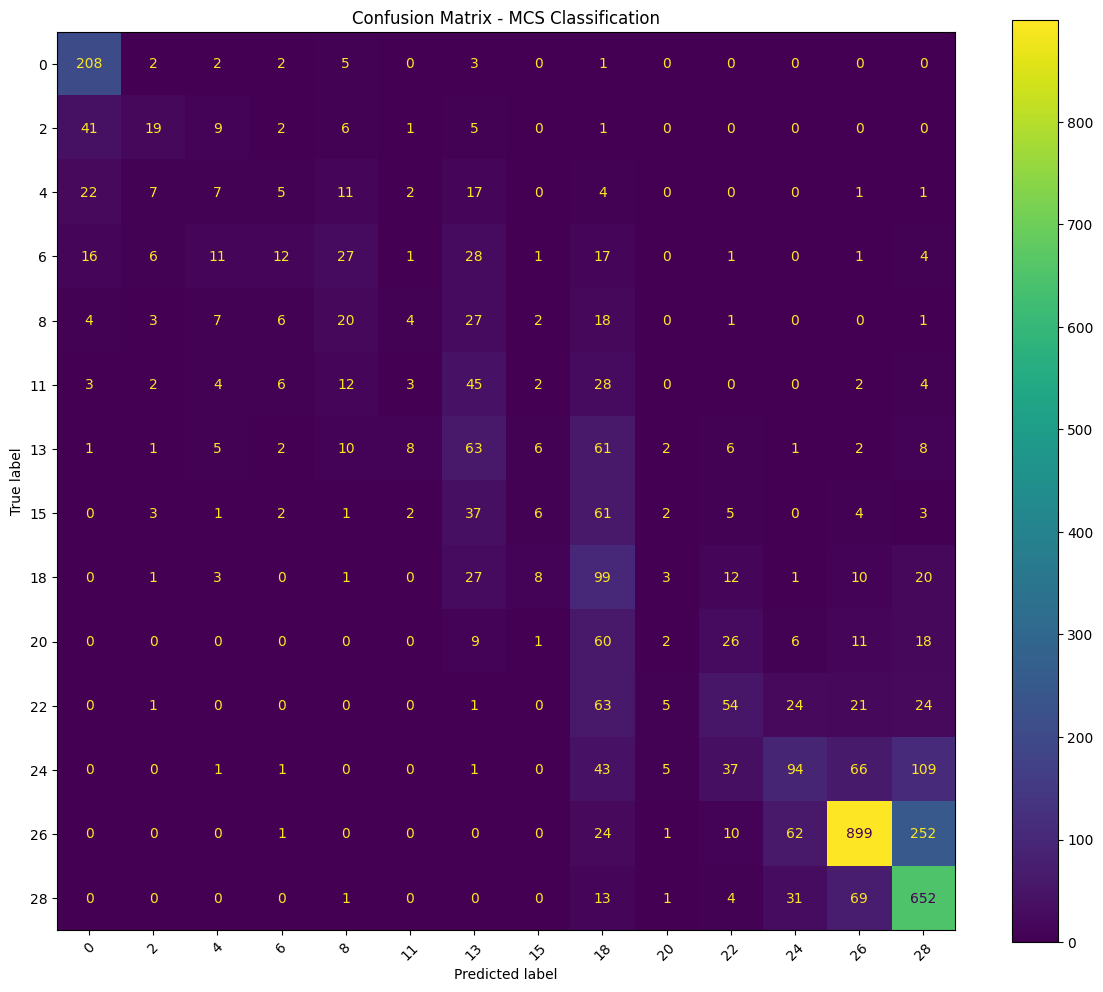

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds, labels=sorted(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(set(labels)))

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='viridis', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - MCS Classification")
plt.grid(False)
plt.tight_layout()
plt.show()


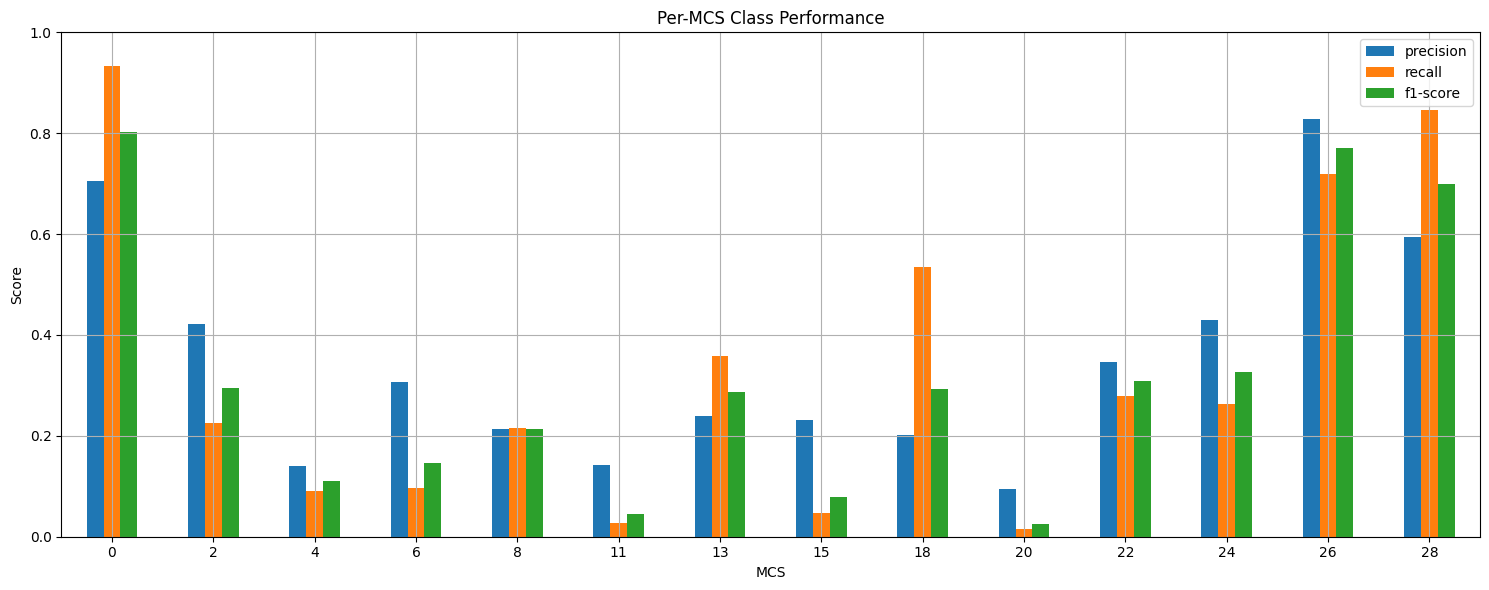

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display only actual MCS classes
df_report_filtered = df_report.loc[df_report.index.str.isnumeric()]
import matplotlib.pyplot as plt

df_report_filtered[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Per-MCS Class Performance")
plt.xlabel("MCS")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [ ]:
y_pred, y_true = evaluate(model, val_loader, device)

In [ ]:
mcs_to_se = {
     0: 0.1523,
     1: 0.2344,
     2: 0.3770,
     3: 0.6016,
     4: 0.8770,
     5: 1.1758,
     6: 1.4766,
     7: 1.9141,
     8: 2.4063,
     9: 2.7305,
    10: 3.3223,
    11: 3.9023,
    12: 4.5234,
    13: 5.1152,
    14: 5.5547,
    15: 6.2266,
    16: 6.9141,
    17: 7.4063,
    18: 7.9141,
    19: 8.4063,
    20: 8.9141,
    21: 9.4063,
    22: 9.9141,
    23: 10.4063,
    24: 10.9141,
    25: 11.4063,
    26: 11.9141,
    27: 12.4063,
    28: 12.9141,
}

In [ ]:
import numpy as np

bandwidth = 100e6  # 100 MHz in Hz

# Map to SE
def mcs_to_throughput(mcs_array):
    se_array = np.array([mcs_to_se.get(m, 0) for m in mcs_array])
    return bandwidth * se_array / 1e6  # in Mbps

# Convert to Mbps
true_throughput = mcs_to_throughput(y_true)
pred_throughput = mcs_to_throughput(y_pred)

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_throughput, pred_throughput)
rmse = mean_squared_error(true_throughput, pred_throughput)

print(f"🔹 Mean Absolute Error (Throughput): {mae:.2f} Mbps")
print(f"🔹 RMSE (Throughput): {rmse:.2f} Mbps")


In [ ]:
print("y_pred unique:", sorted(set(y_pred)))
print("y_true unique:", sorted(set(y_true)))


### MiniRocket

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 1A) Flatten each window from shape (2,10) → (20,)
#     i.e. concatenate SINR[0..9] and CQI[0..9] into a single vector
N = X_scaled.shape[0]
flattened = X_scaled.reshape(N, -1)  # now shape = (N, 20)

# 1B) One‐hot encode RNTI (or you can do LabelEncoder + get dummies)
rnti_col = rnti_raw.reshape(-1, 1)   # shape = (N, 1)
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(rnti_col)                    # learns one‐hot for every RNTI seen
R_onehot = ohe.transform(rnti_col)   # shape = (N, num_unique_RNTI)

# 1C) Concatenate flattened + RNTI one‐hot → a final feature matrix `G`
G = np.concatenate([flattened, R_onehot], axis=1)  # shape = (N, 20 + num_RNTI)
print("G.shape =", G.shape)  # e.g. (N, 20 + 200) if 200 distinct RNTIs


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

In [ ]:
import numpy as np
from minirocket import MiniRocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import OneHotEncoder

# 1) Suppose X_scaled has shape (N, 2, T)  (T=10),  y_raw ∈ [0..num_classes-1],  rnti_raw ∈ [0..num_rntis-1]

# 2) Instantiate MiniROCKET featurizer
rocket = MiniRocket(num_kernels=10_000,  # default ~10k features
                    normalise=False)     # SINR/CQI are already scaled

# Fit on (N, T, in_channels)—MiniROCKET expects shape (N, T, C)
X_for_rocket = np.transpose(X_scaled, (0, 2, 1))  # (N, T, 2)
rocket.fit(X_for_rocket)                           # no labels needed

# 3) Transform into feature matrix: F ∈ ℝ^(N × num_kernels)
F = rocket.transform(X_for_rocket)                 # shape = (N, num_kernels)

# 4) One‐hot‐encode RNTI (with an “unknown” row if you want to hold out IDs)
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
rnti_train = rnti_raw.reshape(-1, 1)   # shape (N,1)
ohe.fit(rnti_train)
R_onehot = ohe.transform(rnti_train)   # shape (N, num_rntis)

# 5) Concatenate MiniROCKET features + RNTI one‐hot: G = [F ∥ R_onehot]
G = np.concatenate([F, R_onehot], axis=1)  # (N, num_kernels + num_rntis)

# 6) Split into train/val (e.g. random‐RNTI or held‐out‐RNTI as before). Here we’ll do a simple 80/20:
from sklearn.model_selection import train_test_split
G_train, G_val, y_train, y_val = train_test_split(G, y_raw, test_size=0.2, random_state=42)

# 7) Fit a multi‐class Ridge with built-in CV (ℓ2 penalty on all features)
clf = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5, class_weight='balanced')
clf.fit(G_train, y_train)

# 8) Evaluate
train_acc = clf.score(G_train, y_train) * 100
val_acc   = clf.score(G_val,   y_val) * 100
print(f"MiniROCKET+Ridge → Train Acc: {train_acc:.2f}%,  Val Acc: {val_acc:.2f}%")


ModuleNotFoundError: No module named 'minirocket'

# Mac Stats


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


path = "//content/drive/MyDrive/5gLADS/sim_results/seed100_run1/NrDlMacStats.txt"
df = pd.read_csv(path, sep="\t")
df.head()

,% time(s),cellId,bwpId,IMSI,RNTI,frame,sframe,slot,symStart,numSym,harqId,ndi,rv,mcs,tbSize
0,0.0235,1,0,2,2,2,4,1,1,2,15,1,0,0,172
1,0.0285,1,0,4,4,2,9,1,1,2,15,1,0,0,172
2,0.0305,1,0,3,3,3,1,1,1,2,15,1,0,0,172
3,0.0725,1,0,1,1,7,3,1,1,2,15,1,0,0,172
4,0.0765,1,0,2,2,7,7,1,1,1,15,1,0,26,1862


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   % time(s)  694 non-null    float64
 1   cellId     694 non-null    int64  
 2   bwpId      694 non-null    int64  
 3   IMSI       694 non-null    int64  
 4   RNTI       694 non-null    int64  
 5   frame      694 non-null    int64  
 6   sframe     694 non-null    int64  
 7   slot       694 non-null    int64  
 8   symStart   694 non-null    int64  
 9   numSym     694 non-null    int64  
 10  harqId     694 non-null    int64  
 11  ndi        694 non-null    int64  
 12  rv         694 non-null    int64  
 13  mcs        694 non-null    int64  
 14  tbSize     694 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 81.5 KB


In [ ]:
import pandas as pd

# Define proper headers based on NrDlMacStats format
columns = [
    "time_s", "cellId", "bwpId", "IMSI", "RNTI", "frame", "sframe", "slot",
    "symStart", "numSym", "harqId", "ndi", "rv", "mcs", "tbSize"
]

# Now read the file, skipping the first comment/header row (starts with '%')
df = pd.read_csv(
    path,
    comment='%',     # Skip header line with '%'
    sep='\s+',
    names=columns
)

print(df.head())


   time_s  cellId  bwpId  IMSI  RNTI  frame  sframe  slot  symStart  numSym  \
0  0.0235       1      0     2     2      2       4     1         1       2   
1  0.0285       1      0     4     4      2       9     1         1       2   
2  0.0305       1      0     3     3      3       1     1         1       2   
3  0.0725       1      0     1     1      7       3     1         1       2   
4  0.0765       1      0     2     2      7       7     1         1       1   

   harqId  ndi  rv  mcs  tbSize  
0      15    1   0    0     172  
1      15    1   0    0     172  
2      15    1   0    0     172  
3      15    1   0    0     172  
4      15    1   0   26    1862  


In [ ]:
df.head(25)

,time_s,cellId,bwpId,IMSI,RNTI,frame,sframe,slot,symStart,numSym,harqId,ndi,rv,mcs,tbSize
0,0.0235,1,0,2,2,2,4,1,1,2,15,1,0,0,172
1,0.0285,1,0,4,4,2,9,1,1,2,15,1,0,0,172
2,0.0305,1,0,3,3,3,1,1,1,2,15,1,0,0,172
3,0.0725,1,0,1,1,7,3,1,1,2,15,1,0,0,172
4,0.0765,1,0,2,2,7,7,1,1,1,15,1,0,26,1862
5,0.0925,1,0,4,4,9,3,1,1,1,15,1,0,15,874
6,0.0945,1,0,3,3,9,5,1,1,1,15,1,0,6,318
7,0.1425,1,0,1,1,14,3,1,1,1,15,1,0,26,1862
8,0.1585,1,0,2,2,15,9,1,1,1,15,1,0,26,1862
9,0.1615,1,0,4,4,16,2,1,1,1,15,1,0,18,1006


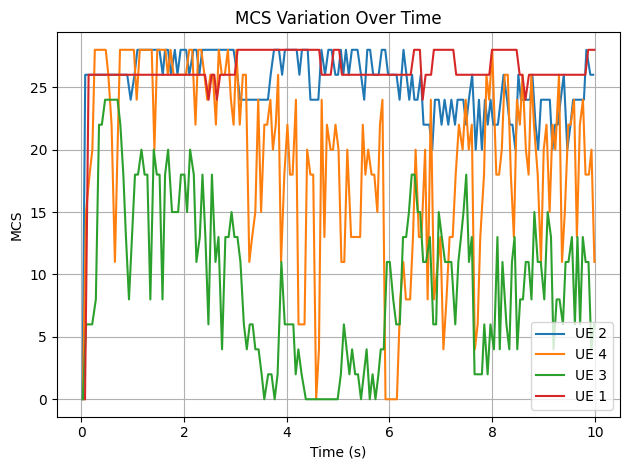

In [ ]:
import matplotlib.pyplot as plt

for rnti in df["RNTI"].unique():
    ue_df = df[df["RNTI"] == rnti]
    plt.plot(ue_df["time_s"], ue_df["mcs"], label=f"UE {rnti}")

plt.xlabel("Time (s)")
plt.ylabel("MCS")
plt.title("MCS Variation Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


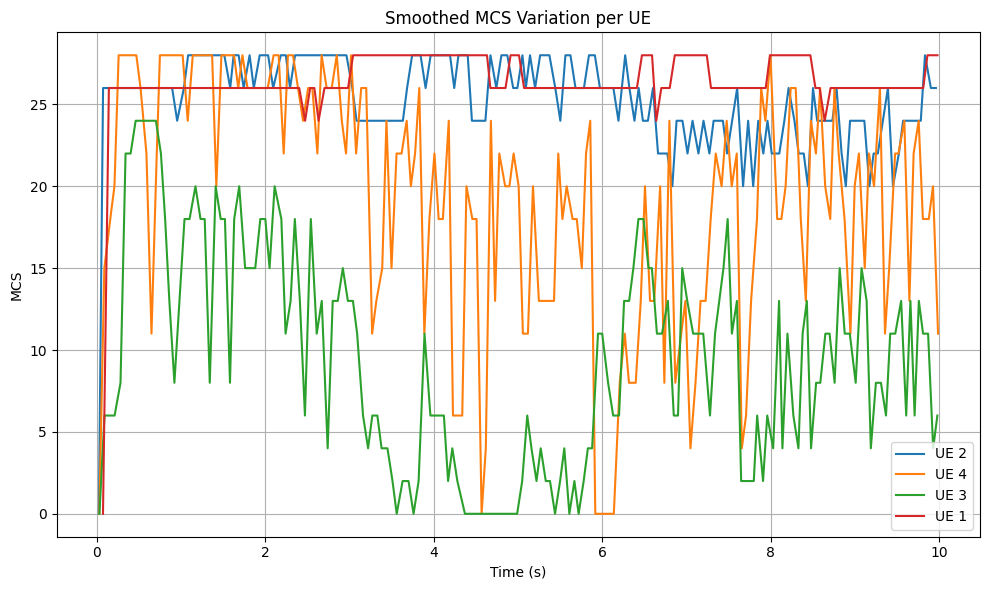

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define columns and read the file
columns = [
    "time_s", "cellId", "bwpId", "IMSI", "RNTI", "frame", "sframe", "slot",
    "symStart", "numSym", "harqId", "ndi", "rv", "mcs", "tbSize"
]
df = pd.read_csv(path, comment='%', sep=r'\s+', names=columns)

# Convert time to TimedeltaIndex so we can resample it properly
df["time_td"] = pd.to_timedelta(df["time_s"], unit='s')

# Plot with smoothed interpolation
plt.figure(figsize=(10, 6))
for rnti in df["RNTI"].unique():
    ue_df = df[df["RNTI"] == rnti].sort_values("time_td")
    ue_df_interp = ue_df.set_index("time_td").resample("10ms").mean().interpolate()
    plt.plot(ue_df_interp.index.total_seconds(), ue_df_interp["mcs"], label=f"UE {rnti}")

plt.xlabel("Time (s)")
plt.ylabel("MCS")
plt.title("Smoothed MCS Variation per UE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


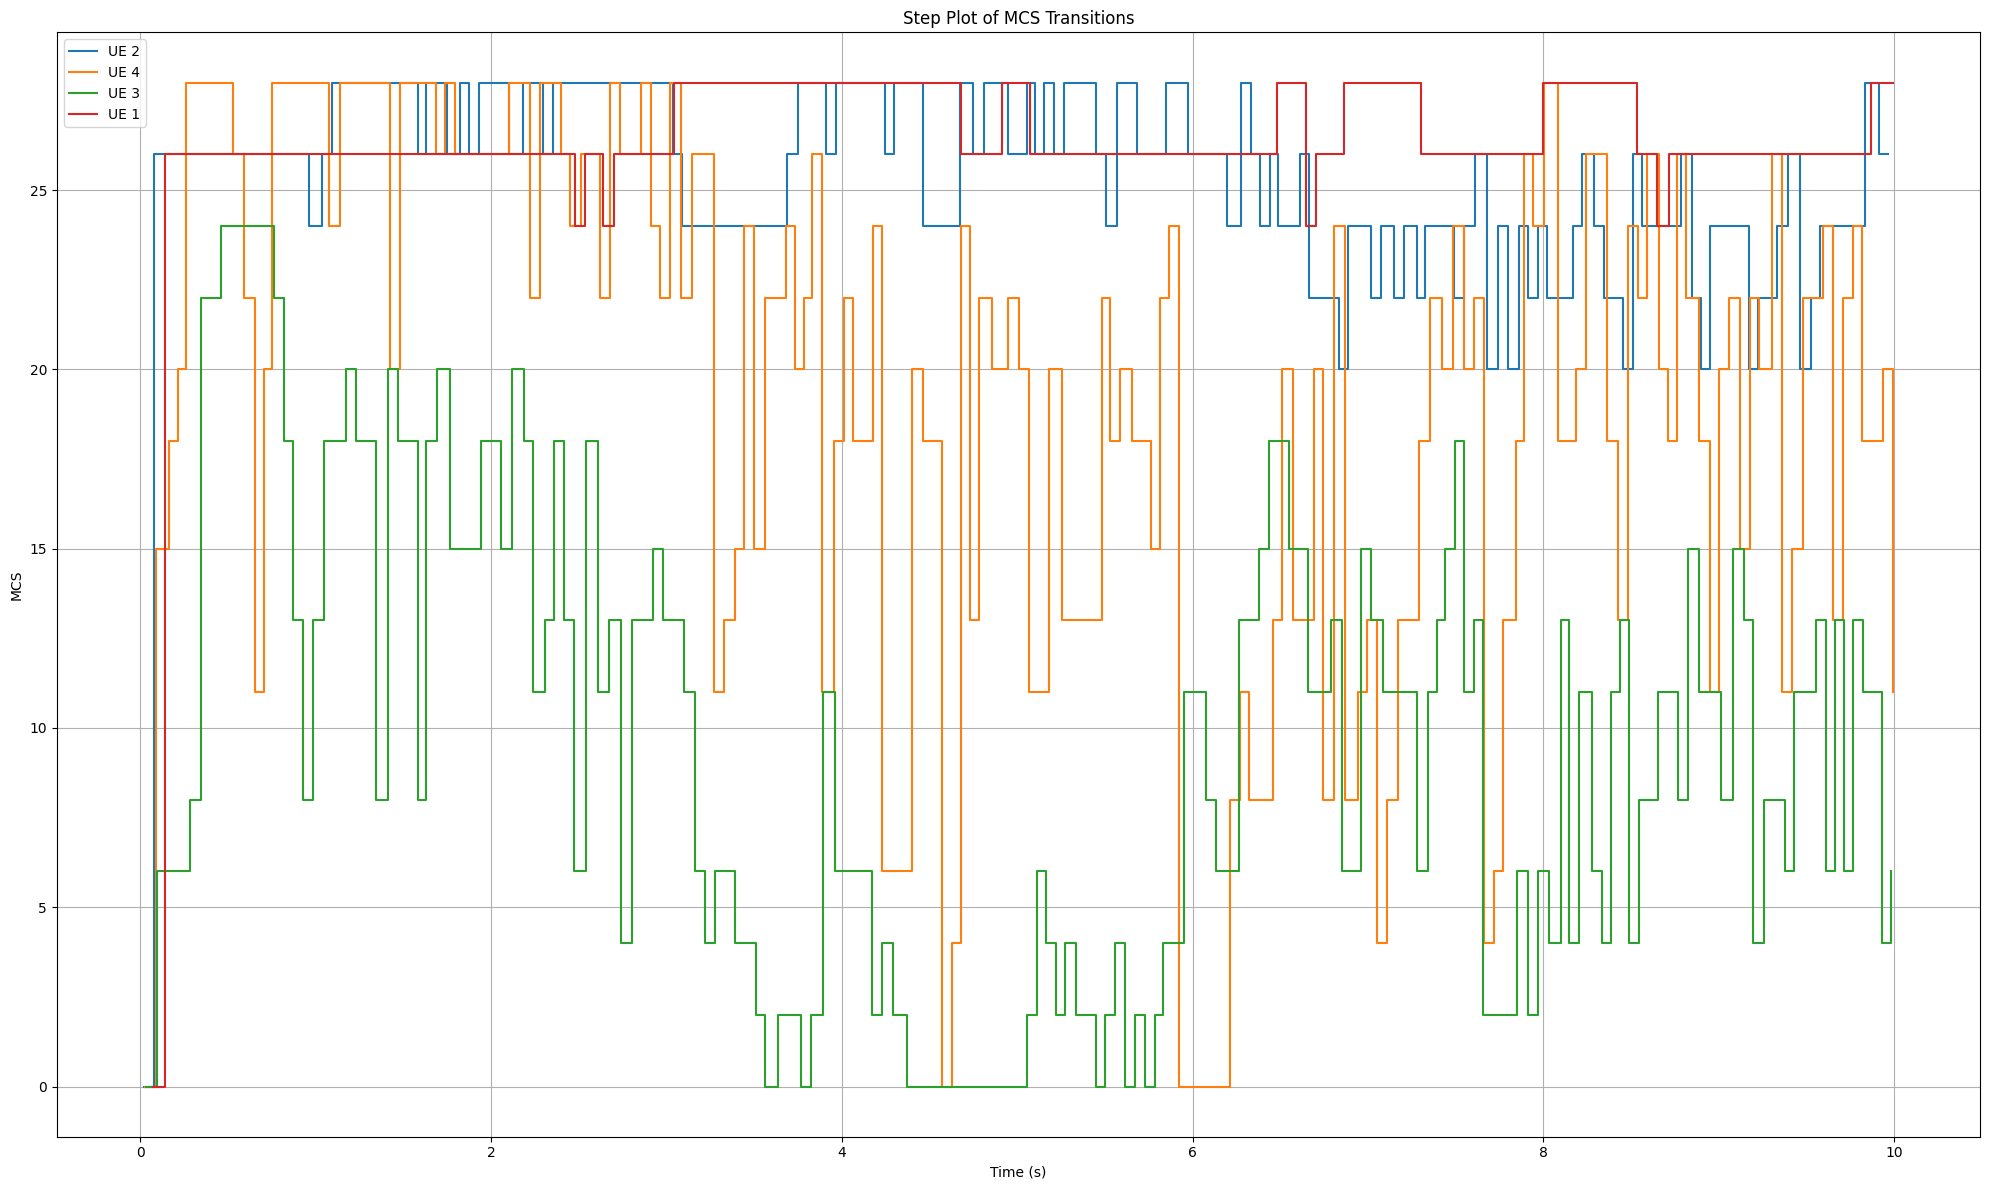

In [ ]:
plt.figure(figsize=(20, 12))
for rnti in df["RNTI"].unique():
    ue_df = df[df["RNTI"] == rnti].sort_values("time_s")
    plt.step(ue_df["time_s"], ue_df["mcs"], where='post', label=f"UE {rnti}")

plt.xlabel("Time (s)")
plt.ylabel("MCS")
plt.title("Step Plot of MCS Transitions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-19-b15c662b0b2a>:8: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


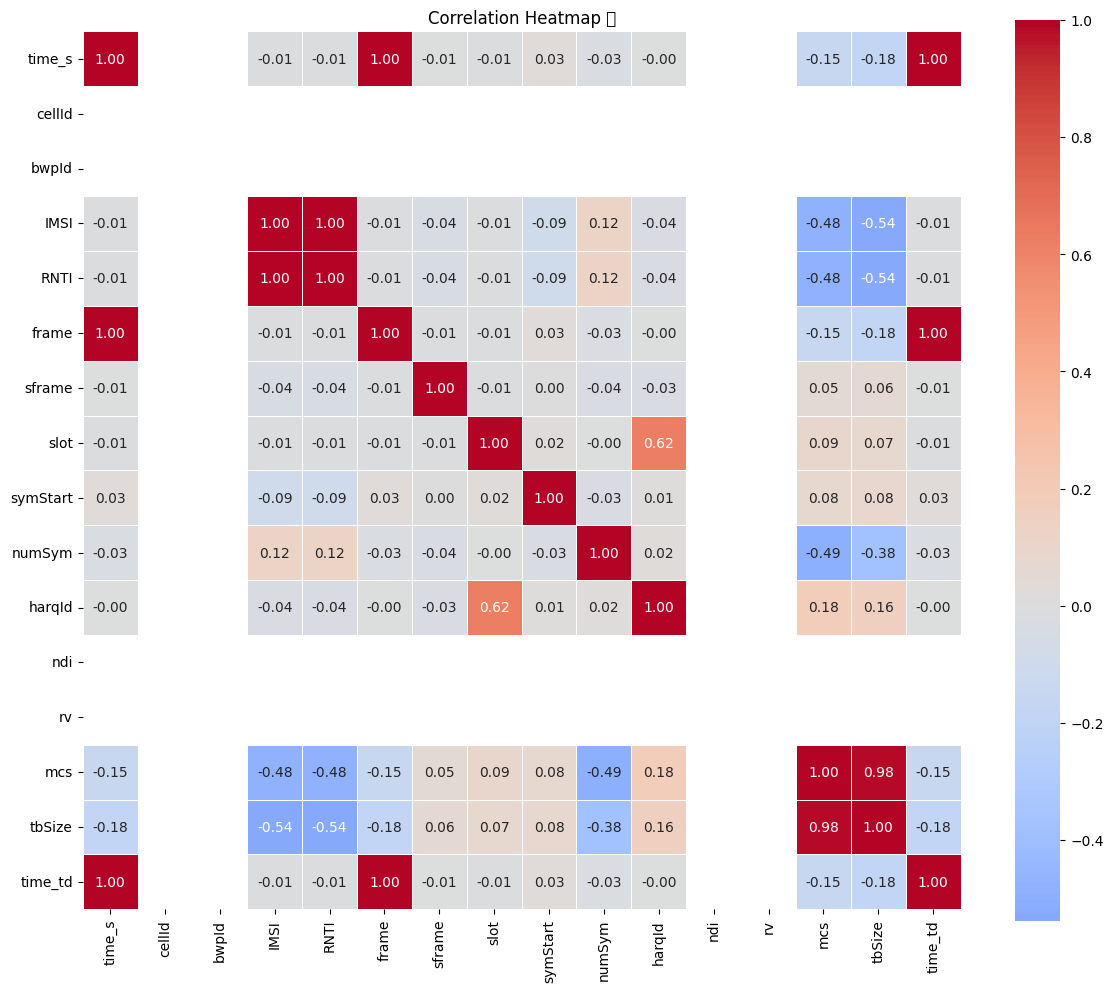

In [ ]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap 🔥")
plt.tight_layout()
plt.show()

#SINR

In [ ]:
sinr_path = "/content/drive/MyDrive/5gLADS/sim_results/seed100_run1/DlDataSinr.txt"
ctrl_sinr_df = pd.read_csv(sinr_path, sep="\t")
print(ctrl_sinr_df.info())
ctrl_sinr_df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      1405 non-null   float64
 1   CellId    1405 non-null   int64  
 2   RNTI      1405 non-null   int64  
 3   BWPId     1405 non-null   int64  
 4   SINR(dB)  1405 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 55.0 KB
None


,Time,CellId,RNTI,BWPId,SINR(dB)
0,0.024607,1,2,0,33.43690
1,0.029607,1,4,0,13.20480
2,0.031607,1,3,0,7.04861
3,0.073607,1,1,0,30.13340
4,0.077571,1,2,0,32.68900
5,0.093571,1,4,0,13.91840
6,0.095571,1,3,0,6.31219
7,0.143571,1,1,0,30.66330
8,0.159571,1,2,0,33.44990
9,0.162571,1,4,0,18.92480


In [ ]:
data_sinr_path = sinr_path = "/content/drive/MyDrive/5gLADS/sim_results/seed100_run1/DlDataSinr.txt"
data_sinr_df = pd.read_csv(data_sinr_path, sep="\t")
print(data_sinr_df.info())
data_sinr_df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24630 entries, 0 to 24629
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      24630 non-null  float64
 1   CellId    24630 non-null  int64  
 2   RNTI      24630 non-null  int64  
 3   BWPId     24630 non-null  int64  
 4   SINR(dB)  24630 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 962.2 KB
None


,Time,CellId,RNTI,BWPId,SINR(dB)
0,0.020607,1,4,0,18.83160
1,0.020679,1,3,0,7.43809
2,0.020750,1,2,0,32.14500
3,0.020821,1,1,0,29.86400
4,0.021607,1,4,0,14.01640
5,0.021679,1,3,0,7.43498
6,0.021750,1,2,0,32.57860
7,0.021821,1,1,0,29.87250
8,0.022607,1,4,0,15.10730
9,0.022679,1,3,0,7.66021


In [ ]:
csi_mac_path = "/content/RxedGnbMacCtrlMsgsTrace.txt"
csi_mac_df = pd.read_csv(csi_mac_path, sep="\t")
print(csi_mac_df.info())
csi_mac_df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49250 entries, 0 to 49249
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     49250 non-null  float64
 1   Entity   49250 non-null  object 
 2   Frame    49250 non-null  int64  
 3   SF       49250 non-null  int64  
 4   Slot     49250 non-null  int64  
 5   VarTTI   49250 non-null  int64  
 6   nodeId   49250 non-null  int64  
 7   RNTI     49250 non-null  int64  
 8   bwpId    49250 non-null  object 
 9   MsgType  0 non-null      float64
dtypes: float64(2), int64(6), object(2)
memory usage: 3.8+ MB
None


,Time,Entity,Frame,SF,Slot,VarTTI,nodeId,RNTI,bwpId,MsgType
0,0.0170,gNB MAC Rxed,1,6,1,1,0,0,RACH_PREAMBLE,NaN
1,0.0170,gNB MAC Rxed,1,6,1,1,1,0,RACH_PREAMBLE,NaN
2,0.0170,gNB MAC Rxed,1,6,1,1,2,0,RACH_PREAMBLE,NaN
3,0.0170,gNB MAC Rxed,1,6,1,1,3,0,RACH_PREAMBLE,NaN
4,0.0220,gNB MAC Rxed,2,2,0,1,4,0,DL_HARQ,NaN
5,0.0220,gNB MAC Rxed,2,2,0,1,3,0,DL_HARQ,NaN
6,0.0220,gNB MAC Rxed,2,2,0,1,2,0,DL_HARQ,NaN
7,0.0220,gNB MAC Rxed,2,2,0,1,1,0,DL_HARQ,NaN
8,0.0225,gNB MAC Rxed,2,2,1,1,4,0,DL_CQI,NaN
9,0.0225,gNB MAC Rxed,2,2,1,1,3,0,DL_CQI,NaN


In [ ]:
csi_phy_path = "/content/RxedGnbPhyCtrlMsgsTrace.txt"
csi_phy_df = pd.read_csv(csi_phy_path, sep="\t")
print(csi_phy_df.info())
csi_phy_df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49751 entries, 0 to 49750
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     49751 non-null  float64
 1   Entity   49751 non-null  object 
 2   Frame    49751 non-null  int64  
 3   SF       49751 non-null  int64  
 4   Slot     49751 non-null  int64  
 5   nodeId   49751 non-null  int64  
 6   RNTI     49751 non-null  int64  
 7   bwpId    49751 non-null  int64  
 8   MsgType  49751 non-null  object 
dtypes: float64(1), int64(6), object(2)
memory usage: 3.4+ MB
None


,Time,Entity,Frame,SF,Slot,nodeId,RNTI,bwpId,MsgType
0,0.0170,gNB PHY Rxed,1,6,1,1,0,0,RACH_PREAMBLE
1,0.0170,gNB PHY Rxed,1,6,1,1,0,0,RACH_PREAMBLE
2,0.0170,gNB PHY Rxed,1,6,1,1,0,0,RACH_PREAMBLE
3,0.0170,gNB PHY Rxed,1,6,1,1,0,0,RACH_PREAMBLE
4,0.0220,gNB PHY Rxed,2,1,1,1,4,0,DL_HARQ
5,0.0220,gNB PHY Rxed,2,1,1,1,3,0,DL_HARQ
6,0.0220,gNB PHY Rxed,2,1,1,1,2,0,DL_HARQ
7,0.0220,gNB PHY Rxed,2,1,1,1,1,0,DL_HARQ
8,0.0225,gNB PHY Rxed,2,2,0,1,4,0,DL_CQI
9,0.0225,gNB PHY Rxed,2,2,0,1,3,0,DL_CQI


Extract DL_CQI reports from RxedGnbMacCtrlMsgsTrace.txt:

* For each entry: get time, RNTI, and mark it as a CQI message.

* Extract MCS data from NrDlMacStats.txt:

* For each entry: get time, RNTI, and MCS.

Align both datasets by:

* Matching on RNTI

* Aligning by time (within a small window, like ±0.005 seconds or interpolate)

Plot a scatter plot:

x-axis: CQI

y-axis: MCS

In [ ]:
print(df.head())
print(csi_mac_df.head())


   time_s  cellId  bwpId  IMSI  RNTI  frame  sframe  slot  symStart  numSym  \
0  0.0195       1      0     0     4      2       0     1         1       2   
1  0.0195       1      0     0     3      2       0     1         3       2   
2  0.0195       1      0     0     2      2       0     1         5       2   
3  0.0195       1      0     0     1      2       0     1         7       2   
4  0.0205       1      0     0     4      2       1     1         1       2   

   harqId  ndi  rv  mcs  tbSize                time_td  
0      15    1   0    0     172 0 days 00:00:00.019500  
1      15    1   0    0     172 0 days 00:00:00.019500  
2      15    1   0    0     172 0 days 00:00:00.019500  
3      15    1   0    0     172 0 days 00:00:00.019500  
4      14    1   0    0     172 0 days 00:00:00.020500  
    Time        Entity  Frame  SF  Slot  VarTTI  nodeId  RNTI          bwpId  \
0  0.017  gNB MAC Rxed      1   6     1       1       0     0  RACH_PREAMBLE   
1  0.017  gNB MAC Rxed 

# Data Cleaning

In [ ]:
import pandas as pd

# --- Load NrDlMacStats.txt ---
mac_stats = pd.read_csv("NrDlMacStats.txt", comment="%", sep='\s+', header=None)
mac_stats.columns = ["time", "cellId", "bwpId", "IMSI", "RNTI", "frame", "sframe", "slot",
                     "symStart", "numSym", "harqId", "ndi", "rv", "mcs", "tbSize"]
mac_stats = mac_stats[["time", "RNTI", "mcs"]]
print(mac_stats.head())

#
# --- Load DlDataSinr.txt ---
sinr = pd.read_csv("DlDataSinr.txt", comment="%", sep='\s+', header=None)
sinr.columns = ["time", "cellId", "RNTI", "bwpId", "sinr_dB"]
sinr = sinr[["time", "RNTI", "sinr_dB"]]

print(sinr.head())

#

     time  RNTI  mcs
0  0.0195     4    0
1  0.0195     3    0
2  0.0195     2    0
3  0.0195     1    0
4  0.0205     4    0
        time  RNTI   sinr_dB
0       Time  RNTI  SINR(dB)
1  0.0206071     4   18.8316
2  0.0206786     3   7.43809
3    0.02075     2    32.145
4  0.0208214     1    29.864


In [ ]:
import pandas as pd

rows = []
with open("RxedGnbMacCtrlMsgsTrace.txt", "r") as f:
    for line in f:
        if line.startswith("%") or line.startswith("Time"):
            continue  # Skip comments and header
        parts = line.strip().split()
        if len(parts) < 11:
            continue  # Skip malformed lines
        try:
            time = float(parts[0])
            entity = " ".join(parts[1:3])  # 'gNB MAC Rxed'
            rest = parts[3:]
            frame= rest[0]
            sframe, slot, vtti = map(int, rest[1:4])
            nodeId, rnti, bwpId = map(int, rest[4:7])
            msg_type = rest[7]
            rows.append([time, entity, frame, sframe, slot, vtti, nodeId, rnti, bwpId, msg_type])
        except ValueError:
            continue  # In case anything fails to parse

# Create DataFrame
cqi_df = pd.DataFrame(rows, columns=[
    "time", "entity", "frame", "sframe", "slot", "VarTTI", "nodeId", "RNTI", "bwpId", "msgType"
])

# Filter for DL_CQI only
cqi = cqi_df[cqi_df["msgType"] == "DL_CQI"][["time", "RNTI"]]
cqi["cqi"] = 1  # Still a placeholder

print(cqi_df.head())
print(cqi.head())

    time   entity frame  sframe  slot  VarTTI  nodeId  RNTI  bwpId  \
0  0.017  gNB MAC  Rxed       1     6       1       1     0      0   
1  0.017  gNB MAC  Rxed       1     6       1       1     1      0   
2  0.017  gNB MAC  Rxed       1     6       1       1     2      0   
3  0.017  gNB MAC  Rxed       1     6       1       1     3      0   
4  0.022  gNB MAC  Rxed       2     2       0       1     4      0   

         msgType  
0  RACH_PREAMBLE  
1  RACH_PREAMBLE  
2  RACH_PREAMBLE  
3  RACH_PREAMBLE  
4        DL_HARQ  
      time  RNTI  cqi
8   0.0225     4    1
9   0.0225     3    1
10  0.0225     2    1
11  0.0225     1    1
16  0.0235     4    1


In [ ]:
# 1. Fix SINR types
sinr["time"] = pd.to_numeric(sinr["time"], errors="coerce")
sinr["RNTI"] = pd.to_numeric(sinr["RNTI"], errors="coerce")
sinr["sinr_dB"] = pd.to_numeric(sinr["sinr_dB"], errors="coerce")

# Rename for consistency
sinr = sinr.rename(columns={"sinr_dB": "sinr"})

# Drop rows with NaNs after coercion
sinr = sinr.dropna().astype({"RNTI": int})

In [ ]:
print(mac_stats.info())
print(sinr.info())
print(cqi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19242 entries, 0 to 19241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    19242 non-null  float64
 1   RNTI    19242 non-null  int64  
 2   mcs     19242 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 451.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 24630 entries, 1 to 24630
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    24630 non-null  float64
 1   RNTI    24630 non-null  int64  
 2   sinr    24630 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 769.7 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 24622 entries, 8 to 49247
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    24622 non-null  float64
 1   RNTI    24622 non-null  int64  
 2   cqi     24622 non-null  int64  
dtypes: float64(1

In [ ]:
import matplotlib.pyplot as plt

def plot_mcs(df_mcs, rnti):
    subset = df_mcs[df_mcs["RNTI"] == rnti]
    print(subset.info())
    plt.figure(figsize=(12, 4))
    plt.plot(subset["time"], subset["mcs"], label="MCS")
    plt.title(f"MCS over Time for RNTI {rnti}")
    plt.xlabel("Time (s)")
    plt.ylabel("MCS")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_sinr(df_sinr, rnti):
    subset = df_sinr[df_sinr["RNTI"] == rnti]
    print(subset.info())
    plt.figure(figsize=(12, 4))
    plt.plot(subset["time"], subset["sinr"], color="orange", label="SINR (dB)")
    plt.title(f"SINR over Time for RNTI {rnti}")
    plt.xlabel("Time (s)")
    plt.ylabel("SINR (dB)")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_cqi(df_cqi, rnti):
    subset = df_cqi[df_cqi["RNTI"] == rnti]
    print(subset.info())
    plt.figure(figsize=(12, 4))
    plt.plot(subset["time"], subset["cqi"], color="green", label="CQI")
    plt.title(f"CQI over Time for RNTI {rnti}")
    plt.xlabel("Time (s)")
    plt.ylabel("CQI (dummy for now)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_mcs(mac_stats, 3)
plot_sinr(sinr, 3)
plot_cqi(cqi, 3)

NameError: name 'mac_stats' is not defined

In [ ]:
print(mac_stats.head(20))
print(sinr.head(20))
print(cqi.head(20))

      time  RNTI  mcs
0   0.0195     4    0
1   0.0195     3    0
2   0.0195     2    0
3   0.0195     1    0
4   0.0205     4    0
5   0.0205     3    0
6   0.0205     2    0
7   0.0205     1    0
8   0.0215     4    0
9   0.0215     3    0
10  0.0215     2    0
11  0.0215     1    0
12  0.0225     4   20
13  0.0225     3    6
14  0.0225     2   26
15  0.0225     1   26
16  0.0235     4   13
17  0.0235     3    6
18  0.0235     2   26
19  0.0235     1   26
        time  RNTI      sinr
1   0.020607     4  18.83160
2   0.020679     3   7.43809
3   0.020750     2  32.14500
4   0.020821     1  29.86400
5   0.021607     4  14.01640
6   0.021679     3   7.43498
7   0.021750     2  32.57860
8   0.021821     1  29.87250
9   0.022607     4  15.10730
10  0.022679     3   7.66021
11  0.022750     2  32.73100
12  0.022821     1  29.97030
13  0.023571     4  15.16090
14  0.023607     3   7.55046
15  0.023643     2  33.08520
16  0.023679     1  29.96620
17  0.024571     4  14.27450
18  0.024607    

In [ ]:
import pandas as pd
import numpy as np

# Assuming mac_stats, sinr, cqi are already defined as your DataFrames

# Get all unique RNTIs across the datasets
unique_rntis = sorted(set(mac_stats["RNTI"]) | set(sinr["RNTI"]) | set(cqi["RNTI"]))

aligned_dfs = []

for rnti in unique_rntis:
    # Filter each dataset by RNTI
    mcs_rnti = mac_stats[mac_stats["RNTI"] == rnti][["time", "mcs"]].copy()
    sinr_rnti = sinr[sinr["RNTI"] == rnti][["time", "sinr"]].copy()

    # Sort SINR data by time (just in case)
    sinr_rnti.sort_values("time", inplace=True)

    # Use pandas.merge_asof to get the last SINR just before each MCS timestamp
    merged = pd.merge_asof(
        mcs_rnti.sort_values("time"),
        sinr_rnti,
        on="time",
        direction="backward",
        tolerance=pd.Timedelta("10ms") if np.issubdtype(mcs_rnti["time"].dtype, np.datetime64) else None
    )

    # Add RNTI column back
    merged["RNTI"] = rnti

    aligned_dfs.append(merged)

# Combine all RNTI-specific data
full_data = pd.concat(aligned_dfs, ignore_index=True)

print(full_data.head(30))


      time  mcs     sinr  RNTI
0   0.0195    0      NaN     1
1   0.0205    0      NaN     1
2   0.0215    0  29.8640     1
3   0.0225   26  29.8725     1
4   0.0235   26  29.9703     1
5   0.0245   26  29.9662     1
6   0.0255   26  29.9983     1
7   0.0265   26  29.9935     1
8   0.0275   26  30.0299     1
9   0.0285   26  30.0366     1
10  0.0295   26  30.0964     1
11  0.0305   24  30.0875     1
12  0.0315   26  30.0798     1
13  0.0325   26  30.0997     1
14  0.0335   26  30.0689     1
15  0.0345   26  30.1261     1
16  0.0355   26  30.1616     1
17  0.0365   26  30.2250     1
18  0.0375   26  30.2101     1
19  0.0385   26  30.1238     1
20  0.0395   26  30.1317     1
21  0.0405   26  30.1223     1
22  0.0415   26  30.1291     1
23  0.0425   26  30.1506     1
24  0.0435   26  30.1369     1
25  0.0445   26  30.1632     1
26  0.0455   26  30.1779     1
27  0.0465   26  30.1267     1
28  0.0475   26  30.1050     1
29  0.0485   26  30.0527     1


In [ ]:
# Assuming full_data is already built from MCS + SINR merging
# And assuming cqi_df is the full CQI dataset including "msgType" and "time", "RNTI"

# Filter only DL_CQI messages
cqi_filtered = cqi_df[cqi_df["msgType"] == "DL_CQI"][["time", "RNTI"]].copy()

# Sort for efficient filtering
cqi_filtered.sort_values(["RNTI", "time"], inplace=True)

# Function to count CQI per interval
def count_cqi_between_intervals(df_mcs_rnti, cqi_rnti):
    cqi_counts = []
    times = df_mcs_rnti["time"].values
    for i in range(len(times)):
        if i == 0:
            cqi_counts.append(np.nan)  # No previous interval
            continue
        start = times[i - 1]
        end = times[i]
        # Count DL_CQI messages in the interval (start, end]
        count = cqi_rnti[(cqi_rnti["time"] > start) & (cqi_rnti["time"] <= end)].shape[0]
        cqi_counts.append(count)
    return cqi_counts

# Add CQI counts to each RNTI's data
final_with_cqi = []

for rnti in full_data["RNTI"].unique():
    df_rnti = full_data[full_data["RNTI"] == rnti].copy().sort_values("time")
    cqi_rnti = cqi_filtered[cqi_filtered["RNTI"] == rnti]

    df_rnti["cqi_count"] = count_cqi_between_intervals(df_rnti, cqi_rnti)
    final_with_cqi.append(df_rnti)

# Merge all together
full_data_with_cqi = pd.concat(final_with_cqi, ignore_index=True)

# Done!
print(full_data_with_cqi.head(30))

      time  mcs     sinr  RNTI  cqi_count
0   0.0195    0      NaN     1        NaN
1   0.0205    0      NaN     1        0.0
2   0.0215    0  29.8640     1        0.0
3   0.0225   26  29.8725     1        1.0
4   0.0235   26  29.9703     1        1.0
5   0.0245   26  29.9662     1        1.0
6   0.0255   26  29.9983     1        1.0
7   0.0265   26  29.9935     1        1.0
8   0.0275   26  30.0299     1        1.0
9   0.0285   26  30.0366     1        1.0
10  0.0295   26  30.0964     1        1.0
11  0.0305   24  30.0875     1        1.0
12  0.0315   26  30.0798     1        1.0
13  0.0325   26  30.0997     1        1.0
14  0.0335   26  30.0689     1        1.0
15  0.0345   26  30.1261     1        1.0
16  0.0355   26  30.1616     1        1.0
17  0.0365   26  30.2250     1        1.0
18  0.0375   26  30.2101     1        1.0
19  0.0385   26  30.1238     1        1.0
20  0.0395   26  30.1317     1        1.0
21  0.0405   26  30.1223     1        1.0
22  0.0415   26  30.1291     1    

In [ ]:
print(full_data_with_cqi["cqi_count"].unique())

[nan  0.  1.  2.  3.  4.  6.  5.  7.]


In [ ]:
clean_data = full_data_with_cqi.dropna().reset_index(drop=True)
print(clean_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19234 entries, 0 to 19233
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       19234 non-null  float64
 1   mcs        19234 non-null  int64  
 2   sinr       19234 non-null  float64
 3   RNTI       19234 non-null  int64  
 4   cqi_count  19234 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 751.5 KB
None


<ipython-input-98-2010cdd3339a>:17: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


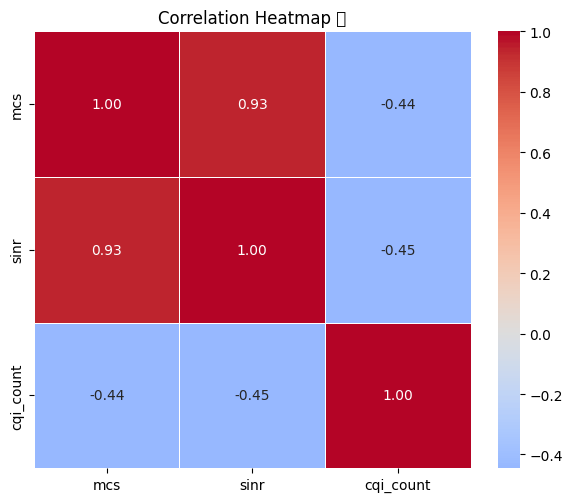

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric columns for correlation
corr_data = full_data_with_cqi[["mcs", "sinr", "cqi_count"]].copy()

# Drop any rows with NaNs (optional, depending on how you want to treat them)
corr_data = corr_data.dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap 🔥")
plt.tight_layout()
plt.show()


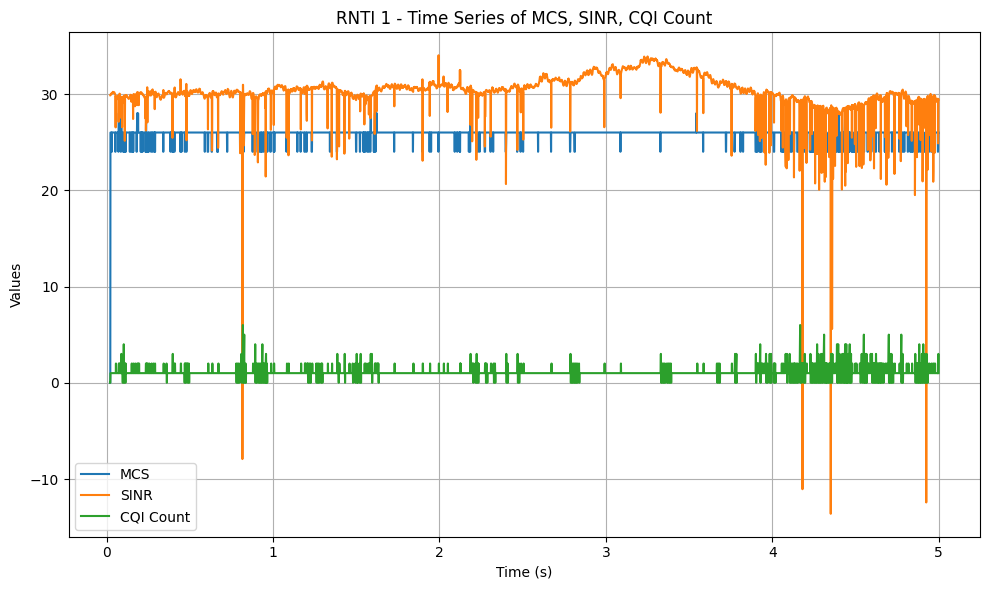

In [ ]:
# Pick a specific RNTI to visualize
sample_rnti = full_data_with_cqi["RNTI"].unique()[0]
rnti_df = full_data_with_cqi[full_data_with_cqi["RNTI"] == sample_rnti]

plt.figure(figsize=(10, 6))
plt.plot(rnti_df["time"], rnti_df["mcs"], label="MCS")
plt.plot(rnti_df["time"], rnti_df["sinr"], label="SINR")
plt.plot(rnti_df["time"], rnti_df["cqi_count"], label="CQI Count")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.title(f"RNTI {sample_rnti} - Time Series of MCS, SINR, CQI Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-100-44e6c8d71a89>:4: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


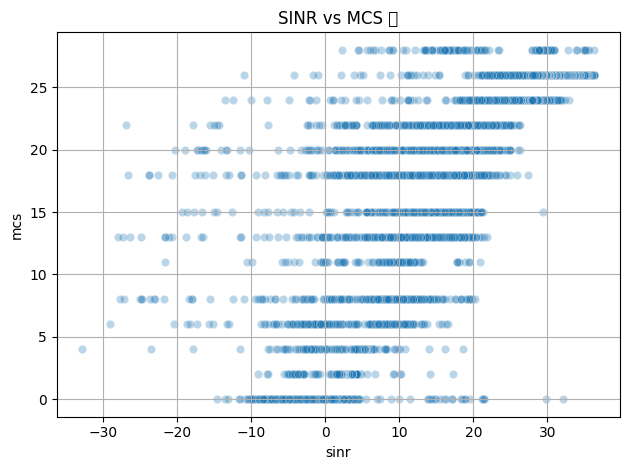

In [ ]:
sns.scatterplot(data=full_data_with_cqi, x="sinr", y="mcs", alpha=0.3)
plt.title("SINR vs MCS 📶")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-101-bf40d1865ca0>:3: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


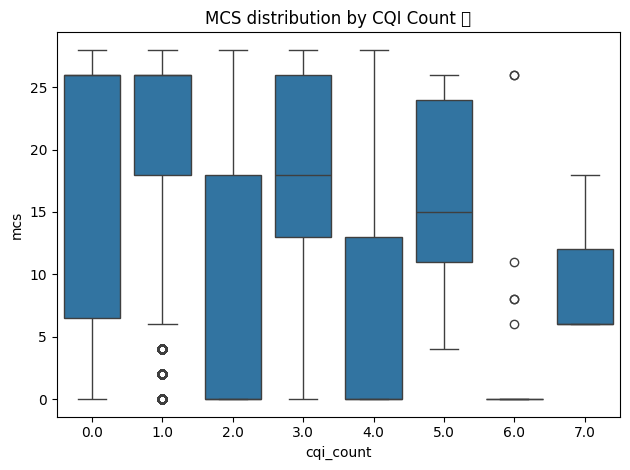

In [ ]:
sns.boxplot(x="cqi_count", y="mcs", data=full_data_with_cqi)
plt.title("MCS distribution by CQI Count 📦")
plt.tight_layout()
plt.show()


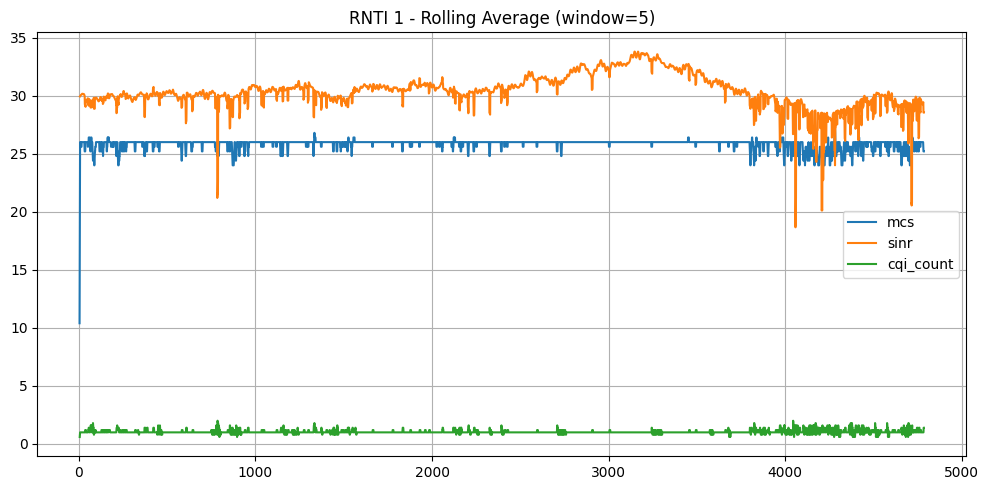

In [ ]:
rnti_df[["mcs", "sinr", "cqi_count"]].rolling(window=5).mean().plot(figsize=(10, 5))
plt.title(f"RNTI {sample_rnti} - Rolling Average (window=5)")
plt.grid(True)
plt.tight_layout()
plt.show()
